In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
import importlib

In [2]:
# %pip install matplotlib yfinance pandas-datareader

In [3]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.cm as cm

import math
from IPython.display import display
import yfinance as yf

import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [293]:
import src
try: 
    for module in [src.models, src.data, src.utils, src.train, src.verification, src.visualisation, src.evaluation]:
        if module:
            importlib.reload(module)
    print("Reloading")
except:
    print("Not reloading")

from src.models import *
from src.data import *
from src.utils import *
from src.train import *
from src.verification import *
from src.visualisation import *
from src.evaluation import *

Reloading


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
trainval_start = "2006-04-02"
trainval_end = "2019-12-31"
test_start = "2020-01-01"
# test_start = "2020-01-01"
test_end = "2022-12-31"

trainval_end = (pd.to_datetime(trainval_end) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")
test_start = (pd.to_datetime(test_start) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")

In [7]:
returns_df, close_df =  get_asset_dataset(trainval_start, test_end)

asset_names = list(returns_df.columns)
n_assets = len(asset_names)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [8]:
trainval_mask = (close_df.index >= trainval_start) & (close_df.index <= trainval_end)
trainval_indices = close_df[trainval_mask].index

val_size = int(0.20 * len(trainval_indices))
train_indices = trainval_indices[:-val_size]
val_indices = trainval_indices[-val_size:]

test_mask = (close_df.index >= test_start) & (close_df.index <= test_end)
test_indices = close_df[test_mask].index

/tmp/ipykernel_2246031/1400509521.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


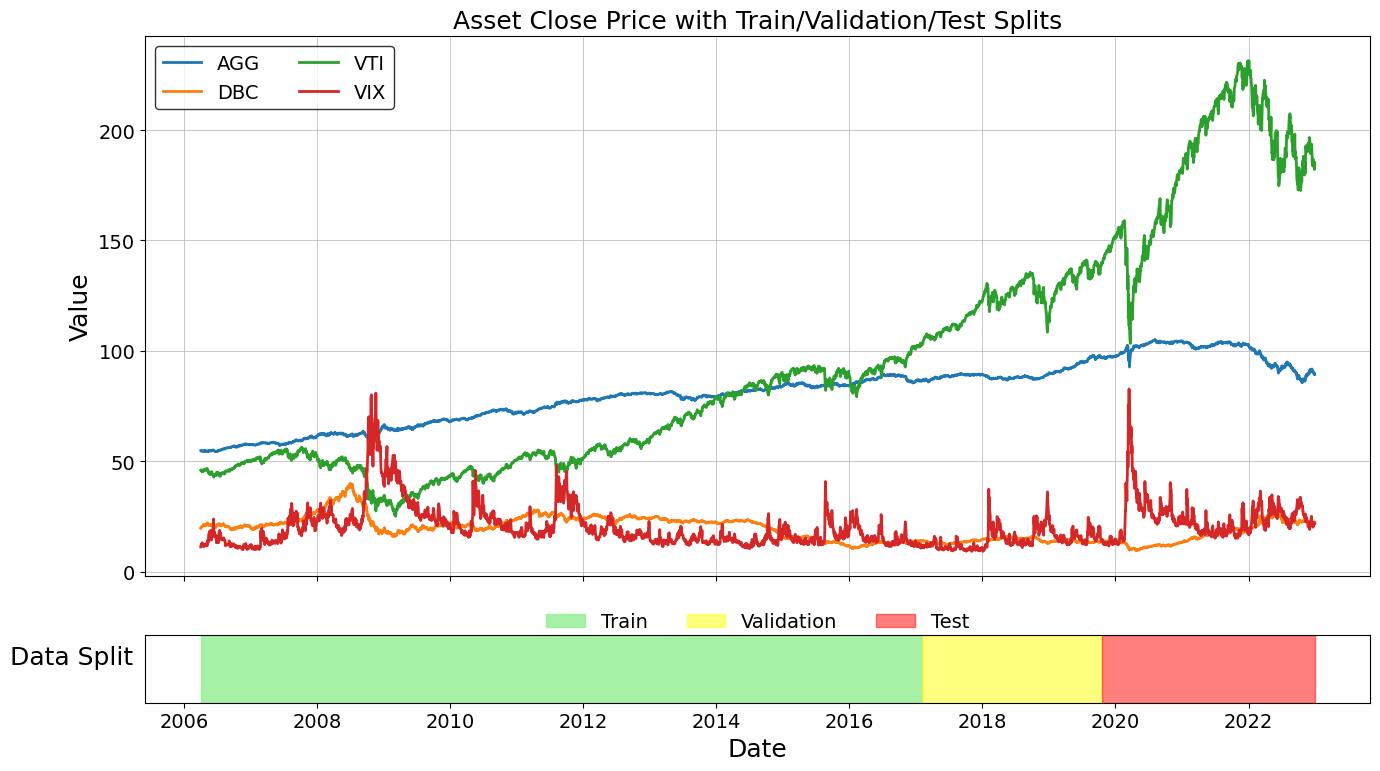

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
colors = cm.get_cmap('tab10')

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#  - `close_df` is a pandas.DataFrame with a datetime-like index,
#    and columns corresponding to each ticker/asset.
#  - `train_indices`, `val_indices`, `test_indices` are each lists/arrays of
#    datetime-like index labels (e.g. pandas Timestamp) in `close_df.index` that define the three splits.
#  - `colors` is a colormap or function such that `colors(i)` returns a distinct color for asset i.
# -----------------------------------------------------------------------------

# Increase default font sizes for PDF readability
plt.rcParams.update({
    "font.size": 16,            # base font size for labels, ticks, legend text
    "axes.titlesize": 18,       # title font size
    "axes.labelsize": 18,       # x/y axis label font size
    "xtick.labelsize": 14,      # x-axis tick label font size
    "ytick.labelsize": 14,      # y-axis tick label font size
    "legend.fontsize": 14,      # legend text font size
})

# Compute start and end dates for each split
train_start = min(train_indices)
train_end = max(train_indices)
val_start = min(val_indices)
val_end = max(val_indices)
test_start = min(test_indices)
test_end = max(test_indices)

# Create subplots: main plot on top, timeline on bottom
fig, (ax_main, ax_timeline) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [8, 1]},
    figsize=(14, 8)
)

# 1) Plot each asset on the main axes
for i, ticker in enumerate(close_df.columns):
    asset_color = colors(i)
    # Plot Train, Validation, Test segments: only label Train for legend
    for idx, label in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"]):
        plot_label = ticker if label == "Train" else "_nolegend_"
        ax_main.plot(
            close_df.loc[idx, ticker],
            color=asset_color,
            linewidth=2,
            label=plot_label
        )

ax_main.set_title("Asset Close Price with Train/Validation/Test Splits")
ax_main.set_ylabel("Value")
ax_main.grid(True, linewidth=0.5)
ax_main.legend(loc="upper left", fontsize="14", ncol=2, frameon=True, edgecolor="black")

# 2) Create the timeline: colored boxes for each split
#    We'll use ax_timeline.axvspan to draw colored regions at y=[0, 1] for each split.
ax_timeline.axvspan(train_start, train_end, color="lightgreen", alpha=0.8, label="Train")
ax_timeline.axvspan(val_start, val_end, color="yellow", alpha=0.5, label="Validation")
ax_timeline.axvspan(test_start, test_end, color="red", alpha=0.5, label="Test")

# Remove y-axis details for timeline
ax_timeline.set_yticks([])
ax_timeline.set_ylabel("Data Split", rotation=0, labelpad=40)
ax_timeline.yaxis.set_label_coords(-0.06, 0.5)
ax_timeline.grid(False)

# Format x-axis as dates
ax_timeline.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_timeline.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

# Add legend for the timeline in the timeline subplot
ax_timeline.legend(loc="center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2))

plt.xlabel("Date")
plt.tight_layout(h_pad=1.0)
plt.show()


In [10]:
lookback = 50   
horizon = 5     
allocation_step = 5

X_train, y_train, train_idx = create_windows(returns_df, train_indices, lookback, horizon)
X_val, y_val, val_idx = create_windows(returns_df, val_indices, lookback, horizon)
X_test, y_test, test_idx = create_windows(returns_df, test_indices, lookback, horizon)

batch_size = 28

X_train_tensor_ = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor_ = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor_ = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

num_samples, seq_len, num_assets = X_train_tensor_.shape
flattened = X_train_tensor_.reshape(-1, num_assets)

mean = flattened.mean(dim=0)  # shape (num_assets,)
std = flattened.std(dim=0)    # shape (num_assets,)

std[std == 0] = 1.0

X_train_tensor = standardize(X_train_tensor_, mean, std)
X_val_tensor = standardize(X_val_tensor_, mean, std)
X_test_tensor = standardize(X_test_tensor_, mean, std)

saved_mean = mean
saved_std = std

In [11]:
# asset_std = X_train_tensor.reshape(-1, X_train_tensor.shape[-1]).std(dim=0)
sigma = 0.025
jitter = Jitter(sigma=sigma)

train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Experiments

In [12]:
def run_experiment(model, data, experiment={}):
    params = experiment.get("params", {})
    rebalance_freq = params.get("rebalance_freq", 252)
    x, y = data
    model.eval()
    n = y.shape[0]

    x = x.to(device)

    portfolio_values,weights,holdings = get_portfolio_value(model, (x,y), rebalance_freq)

    weights = torch.tensor(weights).squeeze(1)
    holdings = torch.tensor(holdings).squeeze(1)


    # returns = portfolio_values.
    cum_returns = portfolio_values - 1

    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]

    # Daily metrics
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe = sharpe_ratio(returns)

    metrics = {
        "expected_return": cum_returns[-1].item(),
        "sharpe_ratio": sharpe,
        "max_drawdown": max_drawdown(portfolio_values),
        "mean_entropy": mean_entropy(weights),
        "mean_return": mean_return,
        "std_return": std_return,
    }

    raw = {
        "weights": weights,
        "returns": returns,
        "cum_returns": cum_returns,
        "holdings": holdings,
    }

    return {"metrics": metrics, "raw": raw}




In [13]:
def default_linestyle_map(params):
    return "-"

def display_train_results(experiments):
    plt.figure(figsize=(10, 6))
    colors = cm.get_cmap('tab10')

    for idx, (label, experiment) in enumerate(experiments.items()):
        if "train_results" not in experiment:
            continue
        # label = label_from_params(experiment["params"], experiments)
        
        data = experiment["train_results"]
        epochs = list(range(1, len(data["train_losses"]) + 1))
        color = colors(idx % 10) 

        plt.plot(epochs, data["train_losses"], label=f"{label} - Train", linestyle='-', color=color)
        plt.plot(epochs, data["val_losses"], label=f"{label} - Val", linestyle='--', color=color)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map=default_linestyle_map, label_from_params=None, additional_detail=False):
    metrics_df  = pd.DataFrame({k: v['results'][dataset_key]["metrics"] for k, v in experiments.items()}).T
    metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)
    display(metrics_df)

    plt.figure(figsize=(10, 6))
    for label, params, cr in [(k, v["params"], v['results'][dataset_key]["raw"]["cum_returns"]) for k, v in experiments.items()]:

        print(cr.shape)
        plt.plot(dataset_idx[::5], cr[::5], label=label, linestyle=linestyle_map(params))

    plt.title(f"Cumulative Returns of Different Models ({dataset_key.title()})")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ncols = 2
    nrows = math.ceil(len(experiments.items()) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Loop through and plot
    for i, (label, weights) in enumerate([(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]):
        ax = axes[i]
        ax.stackplot(dataset_idx, weights.T.detach().numpy(), labels=asset_names)
        ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Proportion')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    if additional_detail:

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
        axes = axes.flatten()

        # Loop through and plot
        for i, (label, holding) in enumerate([(k, v['results'][dataset_key]["raw"]["holdings"]) for k, v in experiments.items()]):
            ax = axes[i]
            ax.plot(dataset_idx, holding.detach().numpy(), label=asset_names)
            ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Proportion')
            ax.legend(loc='upper left')
            ax.grid(True)

        # Hide any unused axes
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))

        for params, weights in [(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]:
            if "epochs" not in params:
                continue
            plt.plot(dataset_idx, entropy(weights).detach().numpy(), label=label)

        plt.axhline(np.log(n_assets), color='gray', linestyle='--', label='Max Entropy (Uniform)')
        plt.title(f'Allocation Entropy Over Time ({dataset_key.title()})')
        plt.xlabel('Date')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics_df    

# Standard Training

In [14]:
# class SimpleAssetAllocationModel(nn.Module):
#     def __init__(self, input_channels=4, output_channels=4):
#         super(SimpleAssetAllocationModel, self).__init__()
        
#         input_size = input_channels
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, output_channels)
#         self.softmax = CustomSoftmax(dim=-1)

#         # self.fc4 = nn.Linear(4*50, 4)

#     def forward(self, x):

#         x = torch.flatten(x, start_dim=-2)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return self.softmax(x)    

In [15]:
class CNNAllocatorCausal(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))

        x = self.fc2(x)
        
        return self.softmax(x)
    
import torch.nn as nn

# class CNNAllocatorCausal(nn.Module):
#     def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
#         super().__init__()

#         # First causal convolution: kernel_size=3, dilation=1 → left padding = 2
#         self.pad1 = nn.ConstantPad1d((2, 0), 0)
#         self.conv1 = nn.Conv1d(
#             in_channels=input_channels,
#             out_channels=32,
#             kernel_size=3,
#             dilation=1,
#             padding=0
#         )

#         # Second causal convolution: kernel_size=3, dilation=1 → left padding = 2
#         self.pad2 = nn.ConstantPad1d((2, 0), 0)
#         self.conv2 = nn.Conv1d(
#             in_channels=32,
#             out_channels=64,
#             kernel_size=3,
#             dilation=1,
#             padding=0
#         )

#         self.relu = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * time_steps, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, input_channels)
#         self.softmax = CustomSoftmax(dim=-1)

#     def forward(self, x):
#         # x: (batch_size, time_steps, input_channels)
#         # transpose to (batch_size, input_channels, time_steps)
#         x = x.transpose(1, 2)

#         # First causal conv
#         x = self.pad1(x)
#         x = self.relu(self.conv1(x))

#         # Second causal conv
#         x = self.pad2(x)
#         x = self.relu(self.conv2(x))

#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return self.softmax(x)

In [144]:
class CNNAllocatorCausal(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
        super().__init__()
        self.time_steps = time_steps

        # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
        # We want to pad 2 zeros on the "time" axis (height) at the top.
        self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad1
        )

        self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad2
        )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        # x: (batch_size, time_steps, input_channels)
        x = x.transpose(1, 2)      # → (B, C, T)
        x = x.unsqueeze(-1)        # → (B, C, T, 1)

        # First causal conv:
        x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
        x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

        # Second causal conv:
        x = self.pad2(x)           # → (B, 32, T+2, 1)
        x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

        # Flatten and FC
        x = self.flatten(x)        # → (B, 64 * T)
        x = self.relu(self.fc1(x)) # → (B, hidden_size)
        x = self.fc2(x)            # → (B, input_channels)
        return self.softmax(x)

In [158]:
class CNNAllocatorCausal2(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))

        x = self.fc2(x)
        
        return self.softmax(x)

In [218]:
def loss_fn_fn(params):
    lambda_entropy = params["lambda_entropy"]
    def loss_fn(x, y, model, _):
        weights = model(x)

        asset_returns = ((1 + y).prod(1)-1)
        portfolio_returns = (asset_returns*weights).sum(1)
        natural_loss = -portfolio_returns.mean() 
        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
        return natural_loss -  entropy_loss
    return loss_fn 
    
def standard_model_fn(params):
    if params["model"] == "CNN":
        return CNNAllocatorCausal3(4, lookback).to(device)
    elif params["model"] == "MLP":
        return SimpleAssetAllocationModel(4*lookback).to(device)
    elif params["model"] == "LSTM":
        hidden_size = params["lstm_hidden_layers"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "LSTM_Unrolled":
        hidden_size = params["lstm_hidden_layers"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM_Unrolled(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "Transformer":
        return Transformer(input_size=50,  output_size=4, d_model=2, nhead=2, num_layers=2, dim_head=4).to(device)

    raise Exception("Model not found")

In [17]:
# model = CNNAllocatorCausal(4, lookback)



In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomSoftmax(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.softmax(x, dim=self.dim)

class CNNAllocatorCausal(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
        super().__init__()
        self.time_steps = time_steps

        # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
        # We want to pad 2 zeros on the "time" axis (height) at the top.
        self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad1
        )

        self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad2
        )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        # x: (batch_size, time_steps, input_channels)
        x = x.transpose(1, 2)      # → (B, C, T)
        x = x.unsqueeze(-1)        # → (B, C, T, 1)

        # First causal conv:
        x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
        x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

        # Second causal conv:
        x = self.pad2(x)           # → (B, 32, T+2, 1)
        x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

        # Flatten and FC
        x = self.flatten(x)        # → (B, 64 * T)
        x = self.relu(self.fc1(x)) # → (B, hidden_size)
        x = self.fc2(x)            # → (B, input_channels)
        return self.softmax(x)


# ----------------------------
# Quick check with dummy input
# ----------------------------
if __name__ == "__main__":
    model = CNNAllocatorCausal(input_channels=4, time_steps=50, hidden_size=100)
    dummy_input = torch.randn(2, 50, 4)  # B=2, T=50, C=4
    output = model(dummy_input)
    print("Dummy input shape:", dummy_input.shape)  # (2, 50, 4)
    print("Output shape:     ", output.shape)       # (2, 4)


Dummy input shape: torch.Size([2, 50, 4])
Output shape:      torch.Size([2, 4])


## CNN - Hyperparameter tuning 

In [226]:
params_grids = [{
    "seed": [2],
    "epochs": [55],
    "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [1e-3],
    "checkpoint_freq": [10],
    "rebalance_freq": [5],
    "jitter" : [0.03],
    # "weight_decay": [1e-4]
}
]


def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn, device=device)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

None
[True, True, True, True, True, True]
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=10.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=20.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=30.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=40.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=50.pt

Hyperparam Search over seeds


,epochs,lambda_entropy,model,learning_rate,checkpoint_freq,rebalance_freq,jitter,checkpoint,mean_val_expected_return
1,55,0.025,CNN,0.001,10,5,0.03,20,3.343098
3,55,0.025,CNN,0.001,10,5,0.03,40,3.269888
4,55,0.025,CNN,0.001,10,5,0.03,50,2.314237
2,55,0.025,CNN,0.001,10,5,0.03,30,2.161916
5,55,0.025,CNN,0.001,10,5,0.03,55,1.878479
0,55,0.025,CNN,0.001,10,5,0.03,10,1.596811


/tmp/ipykernel_2246031/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


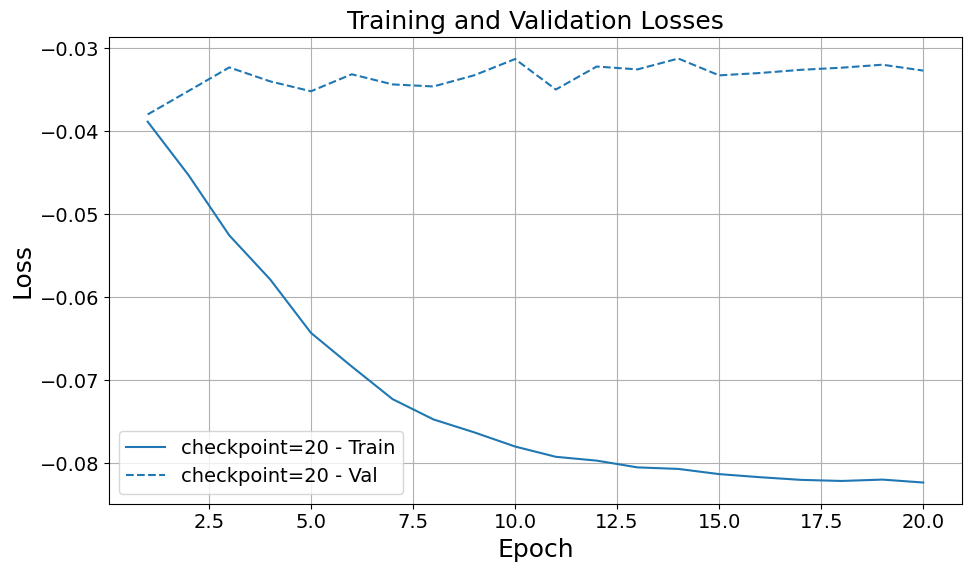

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
checkpoint=20,10.6,0.0907,0.409,0.891,0.00429,0.0473


(752,)


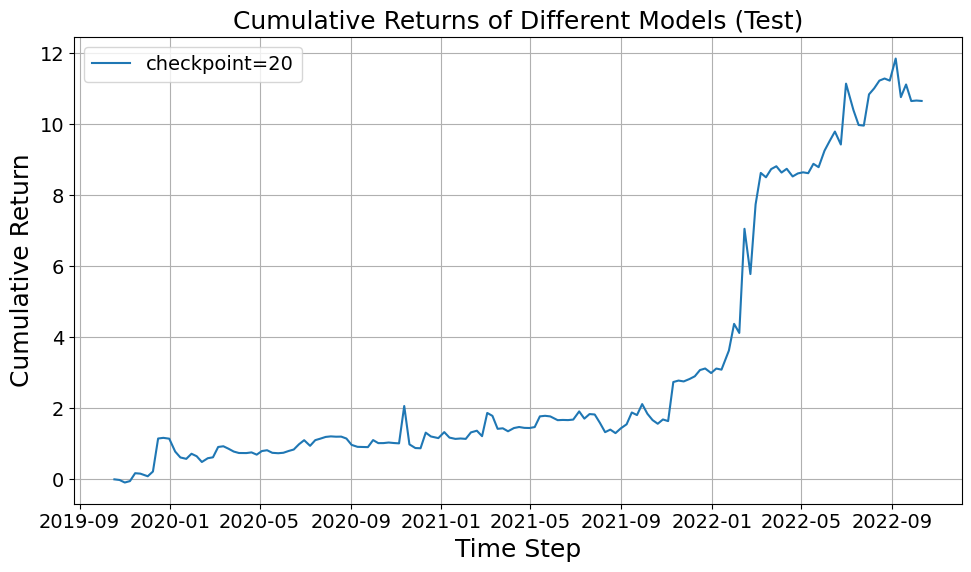

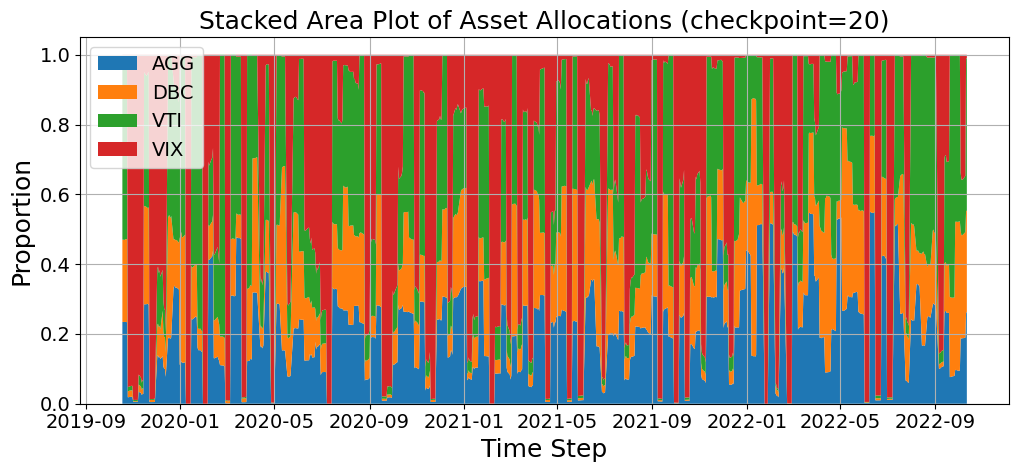

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
checkpoint=20,3.34,0.0716,0.414,0.86,0.00348,0.0486


(626,)


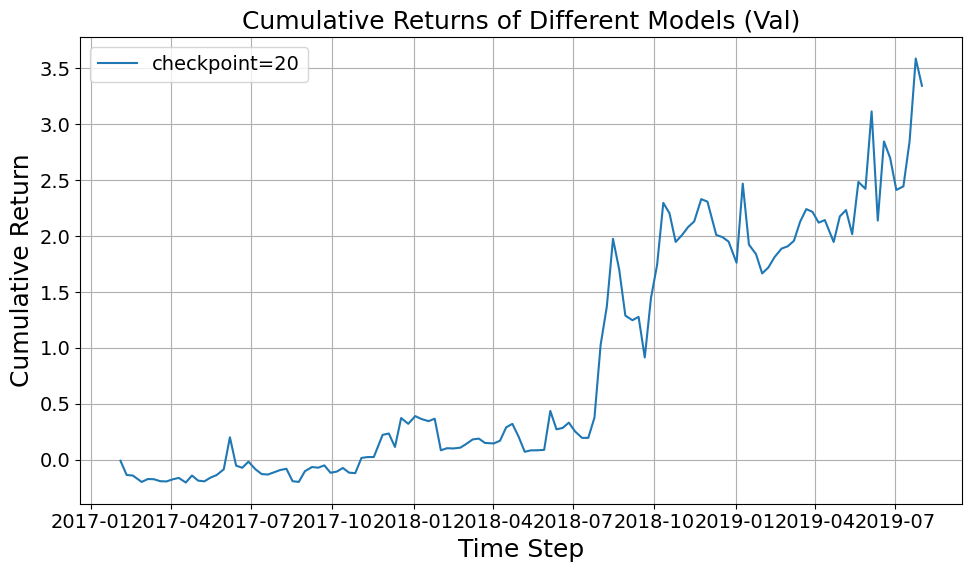

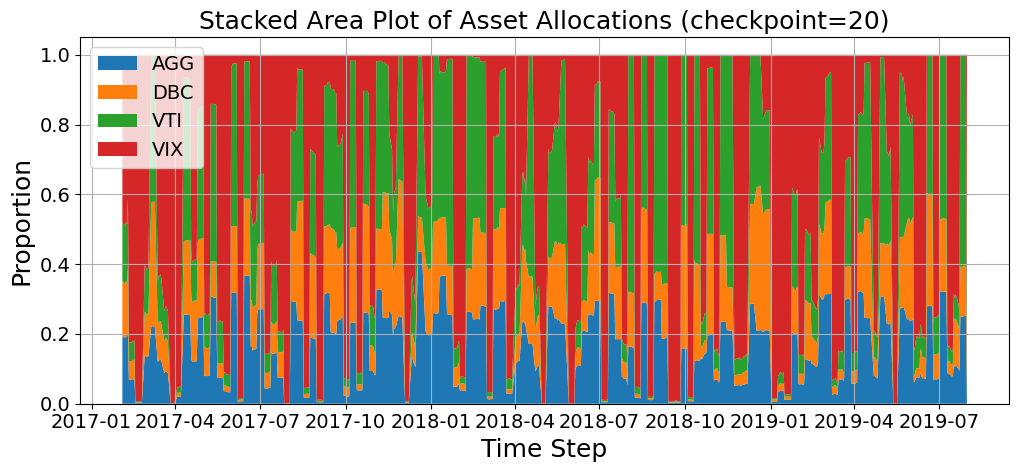

In [227]:
def hyperparam_search(experiments, metric="val_expected_return"):
    params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
    results_df = params_df
    for df_name in ["val", "test"]:
        df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
        df = df.add_prefix(f'{df_name}_')
        results_df = pd.concat([results_df, df], axis=1)

    metric = "val_expected_return"
    params = params_df.columns 
    group_by_params = [p for p in params if p!= "seed"]
    agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
    print("Hyperparam Search over seeds")
    display(agg_results_df)
    best_params = agg_results_df[group_by_params].iloc[0].to_dict()

    for col, val in best_params.items():
        results_df = results_df[results_df[col] == val]

    results_df = results_df.sort_values(metric, ascending=False)[params].iloc[0]
    return results_df.to_dict()

best_params = best_CNN_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
# filtered_experiements = experiments
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

In [228]:
true_filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in best_params])}


In [229]:
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}
for model_name, experiment in experiments.items():
    model = experiment["model"]
    # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [230]:
best_params

{'seed': 2,
 'epochs': 55,
 'lambda_entropy': 0.025,
 'model': 'CNN',
 'learning_rate': 0.001,
 'checkpoint_freq': 10,
 'rebalance_freq': 5,
 'jitter': 0.03,
 'checkpoint': 20}

In [231]:

experiment = list(true_filtered_experiements.values())[0]
model_path = os.path.join(experiment_path, model_file_name(experiment["params"]))
model_path

'alpha-beta-CROWN/complete_verifier/trained_models/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=20.pth'

/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
final,10.6,0.0907,0.409,0.891,0.00429,0.0473
baseline,0.356,0.0289,0.452,1.35,0.000792,0.0274


(752,)
(752,)


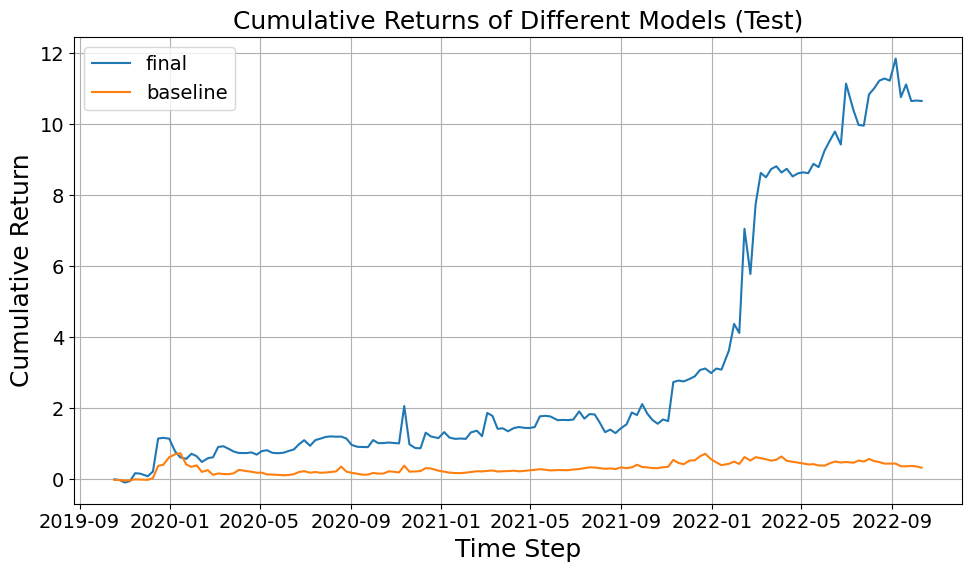

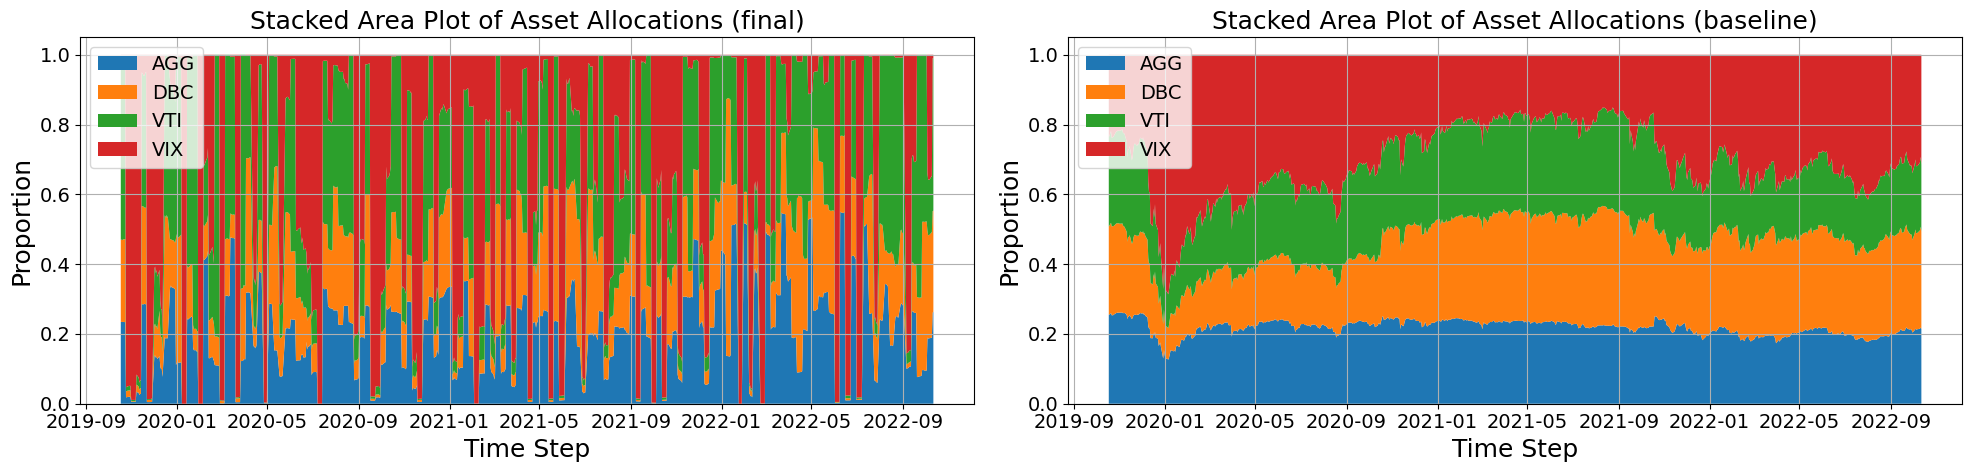

,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
final,10.6,0.0907,0.409,0.891,0.00429,0.0473
baseline,0.356,0.0289,0.452,1.35,0.000792,0.0274


In [232]:
display_experiment_results({"final": experiment, "baseline": experiments["Uniform Baseline"]}, "test", test_idx)

In [289]:

experiment = list(true_filtered_experiements.values())[0]
model_path = os.path.join(experiment_path, model_file_name(experiment["params"]))
model_path

'fyp3/experiments/robust_model/seed=2,epochs=55,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,jitter=0.03,checkpoint=20.pth'

In [ ]:
import pickle
from IPython import get_ipython


def run_abcrown_from_dict_ipython(args_dict, debug_file):
    cmd = "python alpha-beta-CROWN/complete_verifier/abcrown.py"

    output_path = args_dict["output_file"]
    results_path = args_dict["results_file"]
    cex_path = args_dict["cex_path"]

    

    if os.path.isfile(output_path):
        os.remove(output_path)
    if os.path.isfile(results_path):
        os.remove(results_path)

    with open(cex_path, "w") as f:
        json.dump( {"x": [], "adv_output": []}, f, indent=2)

    # data =

    
    # Append each argument with "--" prefix
    for key, value in args_dict.items():
        cmd += f" --{key} {value}"

    cmd = f"{cmd} > {debug_file}"

    get_ipython().system(cmd)



In [260]:
default_params = {
    "config": "jamie.yaml",
    "device": "cuda",
    "start": "0",
    "end": "4",
    "conv_mode": "matrix",
    "load_model": model_path,

}

results = {}#20

force_run = True

test_eps = [0.005, 0.01, 0.02, 0.05, 0.1]
test_delta = [0.05, 0.1, 0.2, 0.3]

test_eps = [0.01]
test_delta = [0.1]


for eps in test_eps:
    results[eps] = {}
    for delta in test_delta:
        path = model_path[:-4] + f"_e={eps}_d={delta}"
        output_path = path + "_output.pkl"
        results_path = path + "_results.txt" 
        debug_path = path + "_debug.txt"  

        print(debug_path)

        if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
            print(f"No results found, running at {eps}, {delta}")
            args = default_params | {
                "epsilon": eps,
                "delta": delta,
                "output_file": output_path,
                "results_file": results_path,
            }
            run_abcrown_from_dict_ipython(args, debug_path)

        
        if os.path.isfile(output_path) and os.path.isfile(results_path):
            print("loading results")
            with open(output_path, "rb") as f:
                output_data = pickle.load(f)
            with open(results_path, "rb") as f:
                results_data = pickle.load(f)   
        else:
            print("failed to load results")
            output_data = None
            results_data = None    

        results[eps][delta] = {"results_data": results_data, "output_data": output_data}

        to_df = []
        for eps, eps_dict in results.items():
            for delta, delta_dict in eps_dict.items():
                summary_agg = {}
                if delta_dict["results_data"] is not None:
                    summary = delta_dict["results_data"]["summary"]
                    for k, v in summary.items():
                        summary_agg[k] = len(v)

                to_df.append({
                    "eps": eps,
                    "delta": delta,
                } | summary_agg)

        display(pd.DataFrame(to_df))


fyp3/experiments/robust_model/seed=2,epochs=2,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=1.5,loss=CROWN-IBP,alpha=0.5,robust_eps=0.05,warmup=20,checkpoint_freq=10,checkpoint=2_e=0.01_d=0.1_debug.txt
No results found, running at 0.01, 0.1
Traceback (most recent call last):
  File "/vol/bitbucket/jlt21/fypv3/alpha-beta-CROWN/complete_verifier/abcrown.py", line 33, in <module>
    from jit_precompile import precompile_jit_kernels
  File "/vol/bitbucket/jlt21/fypv3/alpha-beta-CROWN/complete_verifier/jit_precompile.py", line 21, in <module>
    from beta_CROWN_solver import LiRPANet
  File "/vol/bitbucket/jlt21/fypv3/alpha-beta-CROWN/complete_verifier/beta_CROWN_solver.py", line 29, in <module>
    from attack import attack_after_crown
  File "/vol/bitbucket/jlt21/fypv3/alpha-beta-CROWN/complete_verifier/attack/__init__.py", line 15, in <module>
    from .attack_pgd import attack, attack_pgd, attack_after_crown
  File "/vol/bitbucket/jlt21/fypv3/alpha-beta-CR

,eps,delta
0,0.01,0.1


In [236]:
def robust_loss_fn_fn(params):
    if params["loss"] == "Standard":
        lambda_entropy = params["lambda_entropy"]
    
        def loss_fn(x, y, model, _):
            weights = model(x)


            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)

            natural_loss = -portfolio_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss -  entropy_loss
        return loss_fn 
    elif params["loss"] == "CROWN-IBP" or params["loss"] == "IBP":
        lambda_entropy = params["lambda_entropy"]
        true_alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        warmup = params["warmup"]
        # eps_vector = torch.tensor(robust_eps, dtype=torch.float32, device=device)
        

        def loss_fn(x, y, model, epoch):

            alpha = true_alpha * (max(epoch, warmup)/ warmup)
            weights = model(x)

            # eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=robust_eps)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])

            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)
            worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)

            natural_loss = -portfolio_returns.mean() 
            robust_loss = -worst_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss * (1-alpha) + robust_loss * alpha + entropy_loss
        return loss_fn
    
    elif params["loss"] in ["MTL-IBP", "Exp-IBP", "CC-IBP"]:
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps = robust_eps
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)
        def pgd_attack_loss(x, y):
            loss = ((1 + y).prod(1) * x).sum(1)
            return loss
        def loss_fn(x, y, model):
            model.eval()
            output_adv = model(pgd_attack(model, x, y, eps_vector, pgd_attack_loss, n_steps=10))
            model.train()
            
            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
            asset_returns = ((1 + y).prod(1)-1)

            weights = model(x)
            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            if params["loss"] == "CC-IBP":
                returns = torch.min(asset_returns * (output_adv * alpha + ub * (1-alpha)), asset_returns * (output_adv * alpha + lb * (1-alpha))).sum(1)
                loss = returns.mean()

                return loss + entropy_loss

            else:
                worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)
                robust_loss = -worst_returns.mean() 
                output_adv
                adv_returns = (output_adv * asset_returns).sum(1)
                adv_loss = -adv_returns.mean() 

                if params["loss"] == "MTL-IBP":
                    loss = (adv_loss *(1 - alpha)) + (robust_loss * alpha) + entropy_loss
                elif params["loss"] == "Exp-IBP":
                    loss = (adv_loss **(1 - alpha)) + (robust_loss ** alpha) + entropy_loss

                return loss
        return loss_fn

In [237]:
def get_bounded_model2(model):

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }

    bound_opts = {
            "optimize_bound_args": beta_crown_args,
            "conv_mode": "matrix"
        }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

In [238]:
# from auto_LiRPA.utils import graph_optimizer
# optimized_model = graph_optimizer(model)  

# # Now wrap in BoundedModule
# # bm = BoundedModule(optimized_model, torch.zeros(1, 50, 4))

In [239]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomSoftmax(nn.Module):
    def __init__(self, dim: int = -1, eps: float = 1e-5):
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        e = torch.exp(x)
        return e / (e.sum(dim=self.dim, keepdim=True) + self.eps)
class CNNAllocatorCausal3(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100):
        super().__init__()
        self.time_steps = time_steps

        # ZeroPad2d pads last two dims. Here (pad_left, pad_right, pad_top, pad_bottom).
        # We want to pad 2 zeros on the "time" axis (height) at the top.
        self.pad1 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=32,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad1
        )

        self.pad2 = nn.ZeroPad2d((0, 0, 2, 0))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 1),
            dilation=(1, 1),
            padding=(0, 0)   # no internal padding; we handle it via pad2
        )

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        # x: (batch_size, time_steps, input_channels)
        x = x.transpose(1, 2)      # → (B, C, T)
        x = x.unsqueeze(-1)        # → (B, C, T, 1)

        # First causal conv:
        x = self.pad1(x)           # → (B, C, T+2, 1)  (padding=2 on top)
        x = self.relu(self.conv1(x))  # → (B, 32, T, 1)

        # Second causal conv:
        x = self.pad2(x)           # → (B, 32, T+2, 1)
        x = self.relu(self.conv2(x))  # → (B, 64, T, 1)

        # Flatten and FC
        x = self.flatten(x)        # → (B, 64 * T)
        x = self.relu(self.fc1(x)) # → (B, hidden_size)
        x = self.fc2(x)            # → (B, input_channels)
        return self.softmax(x)


# ----------------------------
# Quick check with dummy input
# # ----------------------------
# if __name__ == "__main__":
#     model = CNNAllocatorCausal(input_channels=4, time_steps=50, hidden_size=100)
#     dummy_input = torch.randn(2, 50, 4)  # B=2, T=50, C=4
#     output = model(dummy_input)
#     print("Dummy input shape:", dummy_input.shape)  # (2, 50, 4)
#     print("Output shape:     ", output.shape)       # (2, 4)

model = get_bounded_model2(CNNAllocatorCausal3())

/vol/bitbucket/jlt21/conda/envs/abcrown/lib/python3.11/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/vol/bitbucket/jlt21/conda/envs/abcrown/lib/python3.11/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(


In [240]:
x = torch.zeros(1, 50, 4).to("cuda")

In [241]:
perturbation = PerturbationLpNorm(norm=np.inf, eps=0.1)
x_perturbed = BoundedTensor(x, perturbation)
ub, lb = model.compute_bounds(x=(x_perturbed,), method="CROWN")

/vol/bitbucket/jlt21/fypv3/alpha-beta-CROWN/auto_LiRPA/auto_LiRPA/bound_general.py:1021: UserWarning: Creating an identity matrix with size 3200x3200 for node BoundConv(name=/input-19, inputs=[/input-15, /3, /4], perturbed=True). This may indicate poor performance for bound computation. If you see this message on a small network please submit a bug report.
  sparse_C = self.get_sparse_C(node, ref_intermediate)


In [248]:
for name, sub in model.named_children():
    print(name, type(sub))

/0 <class 'auto_LiRPA.operators.leaf.BoundInput'>
/1 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/2 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/3 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/4 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/5 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/6 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/7 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/8 <class 'auto_LiRPA.operators.leaf.BoundParams'>
/9 <class 'auto_LiRPA.operators.reshape.BoundTranspose'>
/10 <class 'auto_LiRPA.operators.constant.BoundConstant'>
/input <class 'auto_LiRPA.operators.reshape.BoundUnsqueeze'>
/12 <class 'auto_LiRPA.operators.constant.BoundConstant'>
/13 <class 'auto_LiRPA.operators.constant.BoundConstant'>
/14 <class 'auto_LiRPA.operators.shape.BoundShape'>
/15 <class 'auto_LiRPA.operators.indexing.BoundGather'>
/16 <class 'auto_LiRPA.operators.constant.BoundConstant'>
/17 <class 'auto_LiRPA.operators.constant.BoundConstant'>
/18 <class 'auto_LiRPA.ope

In [ ]:
best_CNN_params = {'seed': [0],
 'epochs': [75],
 'lambda_entropy': [0.025],
 'model': ['CNN'],
 'learning_rate': [0.001],
 'rebalance_freq': [5],
 'jitter': [0.03],
  "loss": ["CROWN-IBP"],
  "alpha": [0.5],
  "robust_eps": [0.01],
  "warmup": [20],
  "checkpoint_freq": [10],
}

experiment_path = "fyp3/experiments/robust_model/"
CNN_experiments = get_experiment_model(lambda x: standard_model_fn(x), experiment_path, best_CNN_params, robust_loss_fn_fn, dataset_fn)
# test_eps = [0.1]

for model_name, experiment in CNN_experiments.items():
    
    model = experiment["model"]

    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

CNN_experiments = {"CNN" : experiment}


None
[False, False, False, False, False, False, False, False]
Training seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10.pth


Epochs:  13%|█▎        | 10/75 [00:38<04:09,  3.84s/ep, train_loss=-0.03807, val_loss=-0.0394456239]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=10.pth


Epochs:  27%|██▋       | 20/75 [01:16<03:30,  3.83s/ep, train_loss=-0.03802, val_loss=-0.0395375110]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=20.pth


Epochs:  40%|████      | 30/75 [01:55<02:53,  3.85s/ep, train_loss=-0.03819, val_loss=-0.0395551623]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=30.pth


Epochs:  53%|█████▎    | 40/75 [02:33<02:14,  3.83s/ep, train_loss=-0.03807, val_loss=-0.0395613397]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=40.pth


Epochs:  67%|██████▋   | 50/75 [03:12<01:36,  3.85s/ep, train_loss=-0.03807, val_loss=-0.0395605298]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=50.pth


Epochs:  80%|████████  | 60/75 [03:50<00:58,  3.88s/ep, train_loss=-0.03817, val_loss=-0.0395680268]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=60.pth


Epochs:  93%|█████████▎| 70/75 [04:29<00:19,  3.89s/ep, train_loss=-0.03836, val_loss=-0.0395543888]

Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=70.pth


Epochs: 100%|██████████| 75/75 [04:48<00:00,  3.85s/ep, train_loss=-0.04124, val_loss=-0.0389773026]


Saving seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75.pth


Hyperparam Search over seeds


,epochs,lambda_entropy,model,learning_rate,rebalance_freq,jitter,loss,alpha,robust_eps,warmup,checkpoint_freq,checkpoint,mean_val_expected_return
0,75,0.025,CNN,0.001,5,0.03,CROWN-IBP,0.5,0.01,20,10,75,1.699101


/tmp/ipykernel_2246031/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


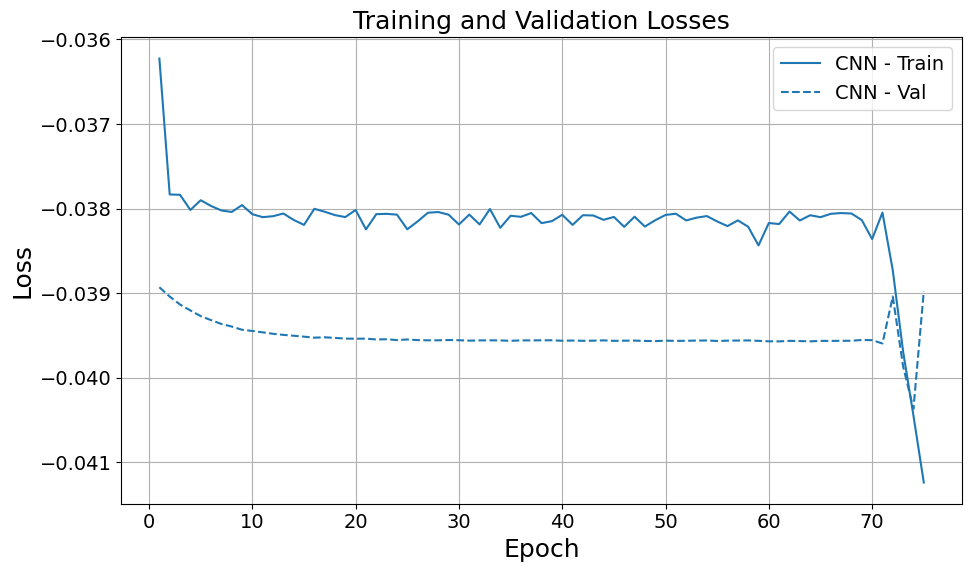

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
CNN,6.78,0.0948,0.339,1.25,0.00337,0.0356


(752,)


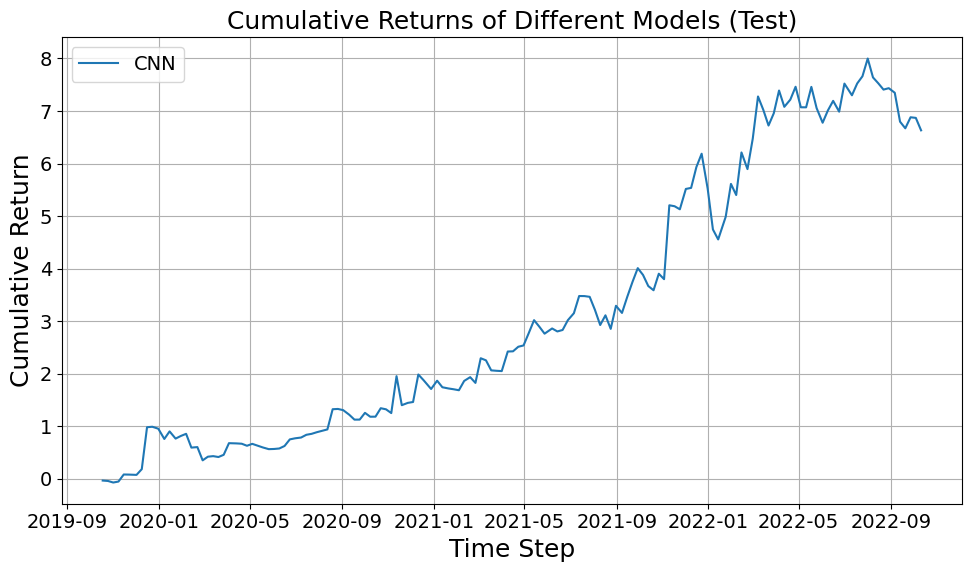

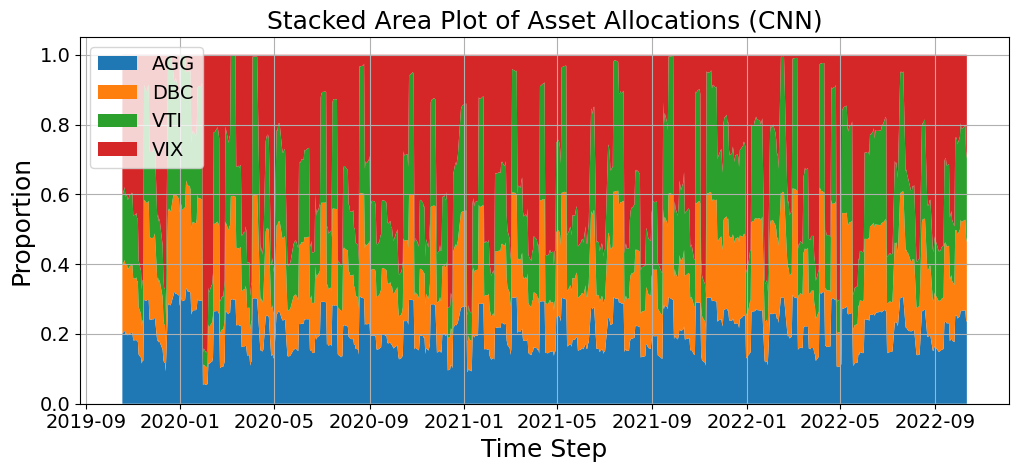

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
CNN,1.7,0.062,0.233,1.24,0.00221,0.0356


(626,)


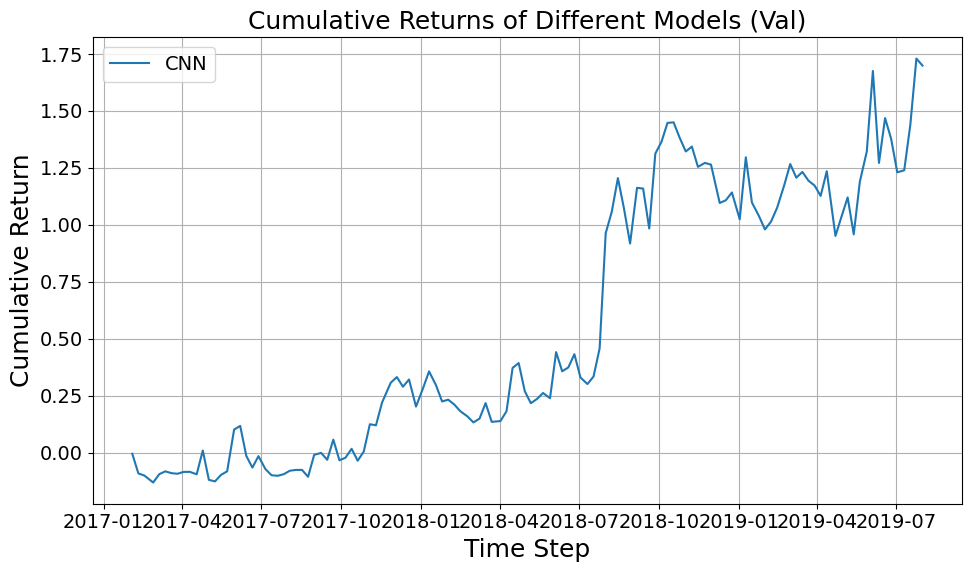

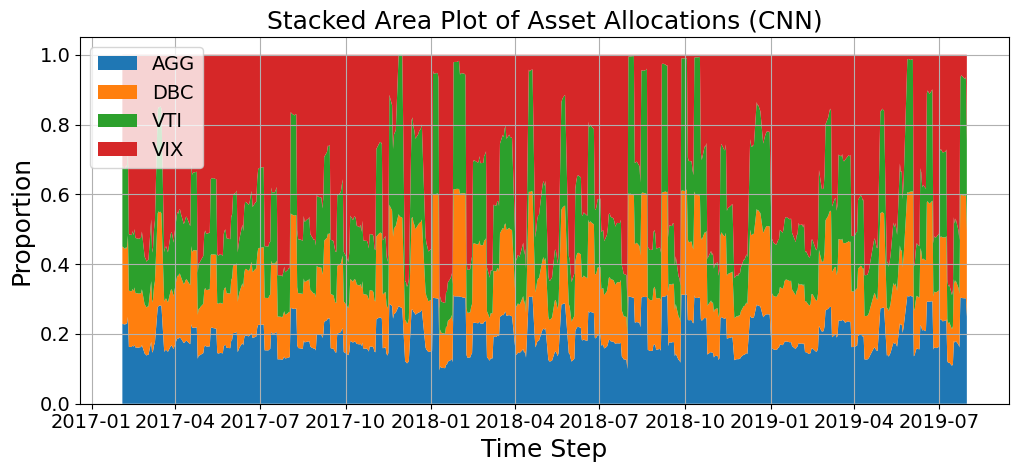

In [ ]:
for model_name, experiment in CNN_experiments.items():
    model = experiment["model"]
    # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
best_params = best_CNN_params = hyperparam_search(CNN_experiments)
filtered_experiements_robust = { ek: e for ek,e in CNN_experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements_robust)
# filtered_experiements = experiments
for dataset_key, dataset_idx in zip(["test", "val", ], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements_robust, dataset_key, dataset_idx )

In [299]:

experiment = list(filtered_experiements_robust.values())[0]
model_path = os.path.join(experiment_path, model_file_name(experiment["params"]))
model_path

'fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75.pth'

In [ ]:
# experiment["model"].

SyntaxError: invalid syntax (1573517440.py, line 1)

In [300]:
model_path

'fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75.pth'

In [ ]:
default_params = {
    "config": "jamie.yaml",
    "device": "cuda",
    "start": "0",
    "end": "25",
    "conv_mode": "matrix",
    "load_model": model_path,
    

}

results = {}#20

force_run = True

test_eps = [0.01, 0.02, 0.05, 0.1]
test_delta = [0.05, 0.1, 0.2, 0.3]

# test_eps = [0.1]
# test_delta = [0.1]


for eps in test_eps:
    results[eps] = {}
    for delta in test_delta:
        path = model_path[:-4] + f"_e={eps}_d={delta}"
        output_path = path + "_output.pkl"
        results_path = path + "_results.txt" 
        cex_path = path + "_cex.json"
        debug_path = path + "_debug.txt"  

        print(debug_path)

        if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
            print(f"No results found, running at {eps}, {delta}")
            args = default_params | {
                "epsilon": eps,
                "delta": delta,
                "output_file": output_path,
                "results_file": results_path,
                "cex_path": cex_path,
            }
            run_abcrown_from_dict_ipython(args, debug_path)

        
        if os.path.isfile(output_path) and os.path.isfile(results_path) and os.path.isfile(cex_path):
            print("loading results")
            with open(output_path, "rb") as f:
                output_data = pickle.load(f)
            with open(results_path, "rb") as f:
                results_data = pickle.load(f)  
            with open(cex_path, "r") as f:
                cex_data = json.load(f)
        else:
            print("failed to load results")
            output_data = None
            results_data = None    

        results[eps][delta] = {"results_data": results_data, "output_data": output_data, "cex_data": cex_data}

        to_df = []
        for eps, eps_dict in results.items():
            for delta, delta_dict in eps_dict.items():
                summary_agg = {}
                if delta_dict["results_data"] is not None:
                    summary = delta_dict["results_data"]["summary"]
                    for k, v in summary.items():
                        summary_agg[k] = len(v)

                to_df.append({
                    "eps": eps,
                    "delta": delta,
                } | summary_agg)

        display(pd.DataFrame(to_df))


fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75_e=0.01_d=0.05_debug.txt
No results found, running at 0.01, 0.05
Configurations:

general:
  device: cuda
  seed: 100
  conv_mode: matrix
  deterministic: false
  double_fp: false
  loss_reduction_func: sum
  sparse_alpha: true
  sparse_interm: true
  save_adv_example: true
  verify_onnxruntime_output: false
  eval_adv_example: false
  show_adv_example: true
  precompile_jit: false
  prepare_only: false
  complete_verifier: skip
  enable_incomplete_verification: true
  csv_name: null
  results_file: 'fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75_e=0.01_d=0.05_results.txt'
  root_path: ''
  deterministic_opt: false
  g

,eps,delta,safe-incomplete
0,0.01,0.05,25


fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75_e=0.01_d=0.1_debug.txt
No results found, running at 0.01, 0.1
^C
failed to load results


,eps,delta,safe-incomplete
0,0.01,0.05,25.0
1,0.01,0.10,NaN


fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75_e=0.01_d=0.2_debug.txt
No results found, running at 0.01, 0.2
Configurations:

general:
  device: cuda
  seed: 100
  conv_mode: matrix
  deterministic: false
  double_fp: false
  loss_reduction_func: sum
  sparse_alpha: true
  sparse_interm: true
  save_adv_example: true
  verify_onnxruntime_output: false
  eval_adv_example: false
  show_adv_example: true
  precompile_jit: false
  prepare_only: false
  complete_verifier: skip
  enable_incomplete_verification: true
  csv_name: null
  results_file: 'fyp3/experiments/robust_model/seed=0,epochs=75,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=0.03,loss=CROWN-IBP,alpha=0.5,robust_eps=0.01,warmup=20,checkpoint_freq=10,checkpoint=75_e=0.01_d=0.2_results.txt'
  root_path: ''
  deterministic_opt: false
  grap

In [374]:
current_result = results[0.1][0.1]
Xc_test_tensor = X_test_tensor.clone()
c = 0
for i in range(0,Xc_test_tensor.shape[0], 5):
    # print(i//5)
    if i // 5 in current_result["results_data"]["summary"]["unsafe-pgd"]:
        avd = torch.tensor(results[0.1][0.1]["cex_data"]["x"][c]).reshape(50,4)
        c += 1
        Xc_test_tensor[i] = avd
  

In [375]:
for model_name, experiment in CNN_experiments.items():
    
    model = experiment["model"]

    # experiment["results"]["fake"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["fake"] = run_experiment(model, (Xc_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

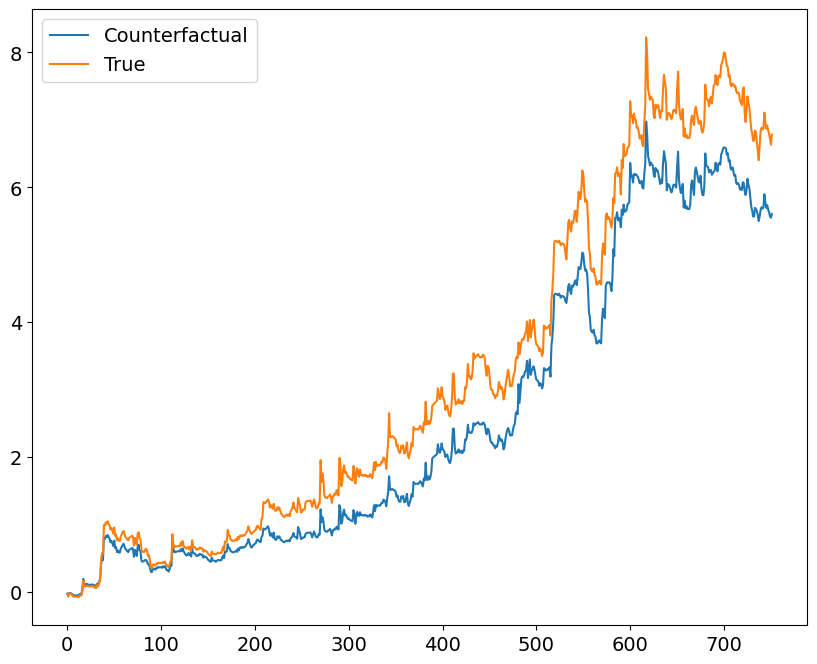

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(experiment["results"]["fake"]["raw"]["cum_returns"], label="Counterfactual")
plt.plot(experiment["results"]["test"]["raw"]["cum_returns"], label="True")
plt.legend()
plt.show()

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
CNN,6.78,0.0948,0.339,1.25,0.00337,0.0356


(752,)


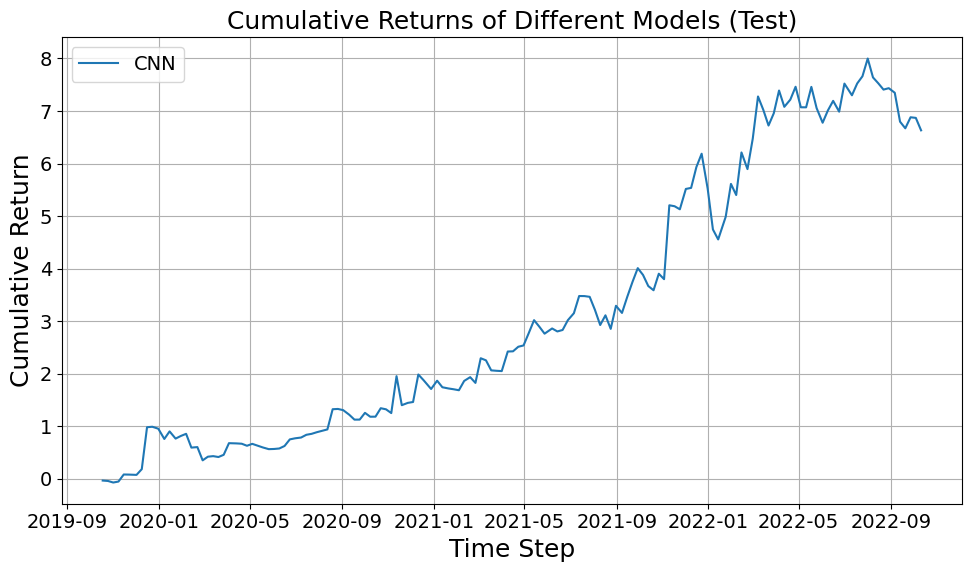

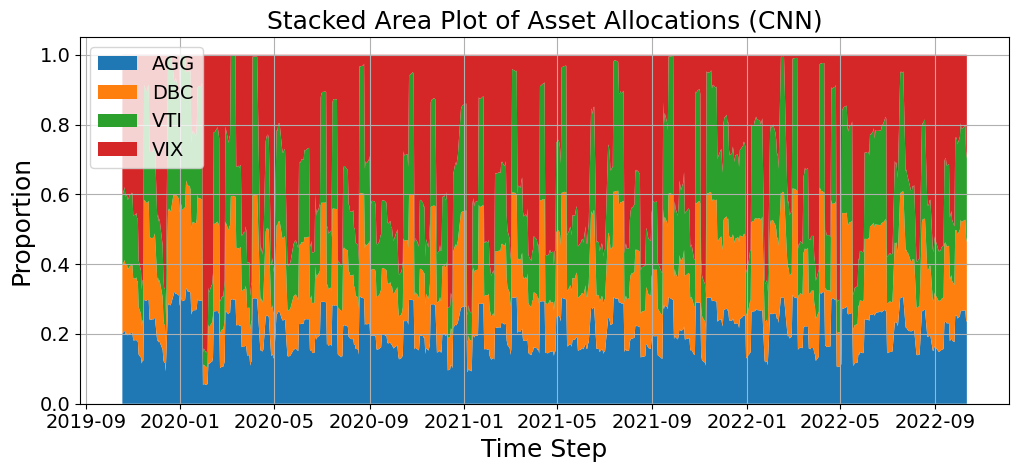

--------------------
Fake RESULTS
--------------------


/tmp/ipykernel_2246031/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
CNN,6.34,0.0949,0.299,1.25,0.00324,0.0341


(752,)


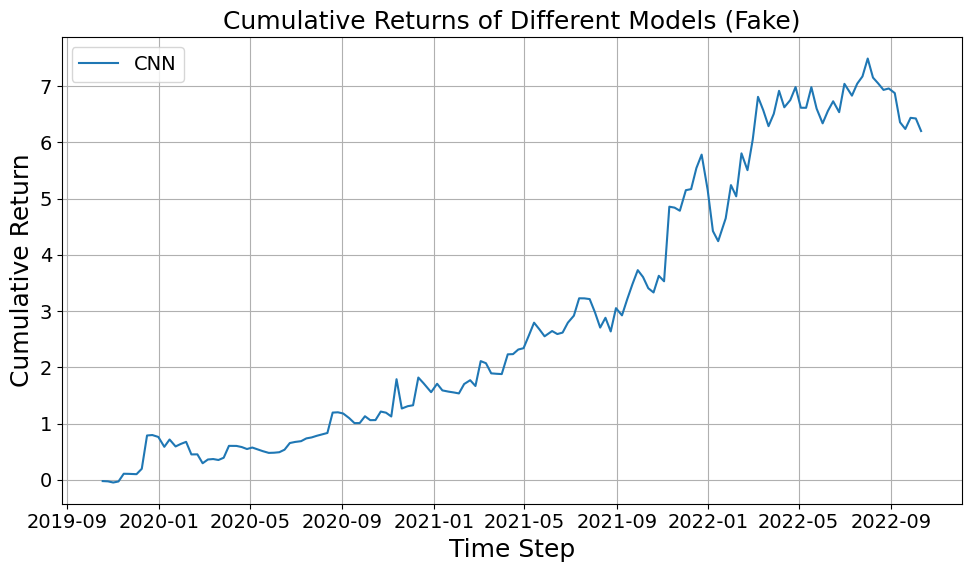

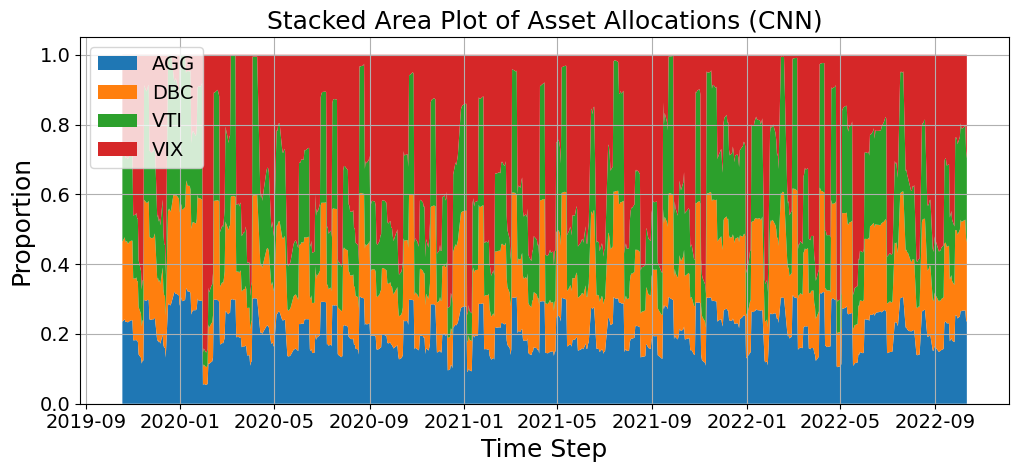

In [ ]:
# for dataset_key, dataset_idx in zip(["test", "fake"], [test_idx,test_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements_robust, dataset_key, dataset_idx )

In [334]:
torch.tensor(results[0.1][0.1]["cex_data"]["x"][0]).reshape(50,4)-X_test_tensor[0]

tensor([[-0.0999, -0.1000, -0.1000,  0.1000],
        [ 0.1000,  0.1000, -0.1000,  0.1000],
        [-0.0999, -0.1000, -0.1000,  0.1000],
        [ 0.0999,  0.1000,  0.1000,  0.1000],
        [-0.1000, -0.1000,  0.1000, -0.1000],
        [ 0.1000,  0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000,  0.1000],
        [ 0.1000, -0.1000, -0.1001,  0.1000],
        [ 0.1002,  0.1000, -0.1000,  0.1000],
        [ 0.0999,  0.1000, -0.1000,  0.1000],
        [-0.1000,  0.1000, -0.1000,  0.1000],
        [ 0.1000, -0.1000,  0.1000, -0.1000],
        [ 0.1001,  0.1000,  0.1000,  0.1000],
        [ 0.0998,  0.1000,  0.1000, -0.1000],
        [ 0.1000, -0.1000,  0.1000, -0.1000],
        [-0.0998,  0.1000,  0.1000, -0.1000],
        [-0.1001,  0.1000,  0.1000, -0.1000],
        [ 0.1000,  0.1000,  0.1000, -0.1000],
        [-0.1001,  0.1000, -0.1000, -0.1000],
        [-0.0999,  0.1000, -0.1000,  0.1000],
        [-0.1001,  0.1000, -0.1000

In [ ]:
# Best results so far

# 	eps	delta	unsafe-pgd	unknown	safe-incomplete
# 0	0.005	0.05	45.0	34.0	72.0
# 1	0.005	0.10	9.0	12.0	130.0
# 2	0.005	0.20	NaN	1.0	150.0
# 3	0.005	0.30	NaN	NaN	151.0
# 4	0.010	0.05	72.0	75.0	4.0
# 5	0.010	0.10	45.0	70.0	36.0
# 6	0.010	0.20	8.0	50.0	93.0
# 7	0.010	0.30	NaN	32.0	119.0
# 8	0.020	0.05	125.0	26.0	NaN
# 9	0.020	0.10	76.0	75.0	NaN
# 10	0.020	0.20	NaN	NaN	NaN


In [ ]:
# 	eps	delta	unsafe-pgd	unknown	safe-incomplete
# 0	0.005	0.05	45.0	34.0	72.0
# 1	0.005	0.10	9.0	12.0	130.0
# 2	0.005	0.20	NaN	1.0	150.0
# 3	0.005	0.30	NaN	NaN	151.0
# 4	0.010	0.05	72.0	75.0	4.0
# 5	0.010	0.10	45.0	70.0	36.0
# 6	0.010	0.20	8.0	50.0	93.0
# 7	0.010	0.30	NaN	32.0	119.0
# 8	0.020	0.05	125.0	26.0	NaN

In [ ]:
# default_params = {
#     "config": "jamie.yaml",
#     "device": "cuda",
#     "start": "0",
#     "end": "64",
#     "conv_mode": "patches",
#     "load_model": model_path,
# }

# results = {}#20

# force_run = True


# for eps in [0.01]:
#     results[eps] = {}
#     for delta in tqdm([0.1, 0.5, 0.25, 0.01]):
#         path = model_path[:-4] + f"_e={eps}_d={delta}"
#         output_path = path + "_output.pkl"
#         results_path = path + "_results.txt" 
#         debug_path = path + "_debug.txt"  

#         print(debug_path)

#         if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
#             print(f"No results found, running at {eps}, {delta}")
#             args = default_params | {
#                 "epsilon": eps,
#                 "delta": delta,
#                 "output_file": output_path,
#                 "results_file": results_path,
#             }
#             run_abcrown_from_dict_ipython(args, debug_path)

        
#         if os.path.isfile(output_path) and os.path.isfile(results_path):
#             print("loading results")
#             with open(output_path, "rb") as f:
#                 output_data = pickle.load(f)
#             with open(results_path, "rb") as f:
#                 results_data = pickle.load(f)   
#         else:
#             print("failed to load results")
#             output_data = None
#             results_data = None    

#         results[eps][delta] = {"results_data": results_data, "output_data": output_data}

In [ ]:
torch.tensor([0.1, 1, 2, 3, 5, 10]) * (saved_std/0.0128 * 0.041)[1]

tensor([0.0041, 0.0412, 0.0823, 0.1235, 0.2058, 0.4116])

In [ ]:
torch.tensor([0.1, 1, 2, 3, 5, 10]) *  0.041 /0.0128 #* (saved_std/ )[1]

tensor([ 0.3203,  3.2031,  6.4063,  9.6094, 16.0156, 32.0313])

In [ ]:
# to_df = []

# for eps, eps_dict in results.items():
#     for delta, delta_dict in eps_dict.items():
#         summary_agg = {}
#         if delta_dict["results_data"] is not None:
#             summary = delta_dict["results_data"]["summary"]
#             for k, v in summary.items():
#                 summary_agg[k] = len(v)

#         to_df.append({
#             "eps": eps,
#             "delta": delta,
#         } | summary_agg)

# pd.DataFrame(to_df)

,eps,delta,safe-incomplete
0,0.01,0.1,2


In [ ]:
# 	eps	delta	unsafe-pgd	unknown	safe-incomplete
# 0	0.10	0.05	35.0	NaN	NaN
# 1	0.10	0.10	34.0	1.0	NaN
# 2	0.10	0.20	31.0	4.0	NaN
# 3	0.10	0.30	30.0	5.0	NaN
# 4	0.50	0.05	35.0	NaN	NaN
# 5	0.50	0.10	35.0	NaN	NaN
# 6	0.50	0.20	35.0	NaN	NaN
# 7	0.50	0.30	35.0	NaN	NaN
# 8	0.25	0.05	35.0	NaN	NaN
# 9	0.25	0.10	35.0	NaN	NaN
# 10	0.25	0.20	35.0	NaN	NaN
# 11	0.25	0.30	35.0	NaN	NaN
# 12	0.01	0.05	14.0	21.0	NaN
# 13	0.01	0.10	10.0	18.0	7.0
# 14	0.01	0.20	1.0	10.0	24.0
# 15	0.01	0.30	NaN	7.0	28.0


In [ ]:
%ls

 alpha-beta-CROWN/
 alpha-beta-CRWON/
'Asset Allocation copy.ipynb'
 fyp3/
 jamie.yaml
 README.md
'Robust Training.ipynb'
 src/
'src copy'/
'Standard Training copy (fixed calculation).ipynb'
'Standard Training copy.ipynb'
'Standard Training.ipynb'
 test_cex.txt


In [ ]:
import torch
import re

# Replace with your actual filename
filename = "test_cex.txt"

# Read the entire file as text
with open(filename, "r") as f:
    text = f.read()

# Use regex to grab all X_i values (in order) and all Y_j values
# This pattern looks for "(X_<digits> <float>)"
x_matches = re.findall(r'\(X_\d+\s+([-+]?\d*\.\d+|\d+)\)', text)
y_matches = re.findall(r'\(Y_\d+\s+([-+]?\d*\.\d+|\d+)\)', text)

# Convert to floats
x_vals = [float(v) for v in x_matches]
y_vals = [float(v) for v in y_matches]

# Sanity check lengths
if len(x_vals) != 200:
    raise ValueError(f"Expected 200 X-values but found {len(x_vals)}")
if len(y_vals) != 4:
    raise ValueError(f"Expected 4 Y-values but found {len(y_vals)}")

# Create 1‐D tensors
X = torch.tensor(x_vals)   # shape: (200,)
Y = torch.tensor(y_vals)   # shape: (4,)

# Reshape X into (50, 4)
X = X.view(50, 4)

print("X shape:", X.shape)  # torch.Size([50, 4])
print("Y shape:", Y.shape)  # torch.Size([4])


X shape: torch.Size([50, 4])
Y shape: torch.Size([4])


In [ ]:
Y 

tensor([0.1336, 0.2101, 0.1388, 0.5175])

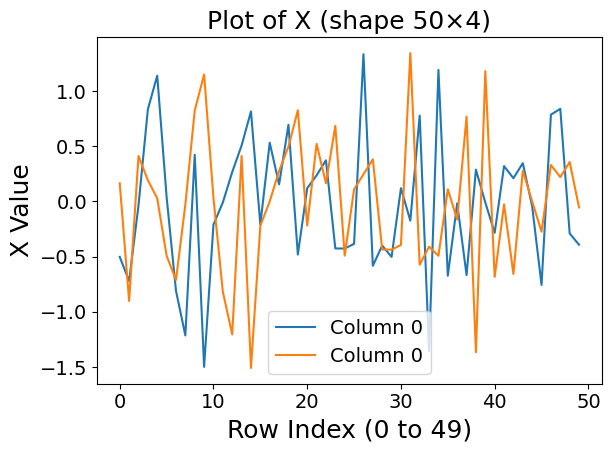

In [ ]:
X_np = X.numpy()
X_true = X_test_tensor[0].numpy()
# ---------------------------------------------------
# STEP 4: Plot each of the 4 columns of X
# ---------------------------------------------------
plt.figure()
for i in range(1):
    plt.plot(X_np[:, i], label=f"Column {i}")
    plt.plot(X_true[:, i], label=f"Column {i}")
    # plt.plot()

plt.xlabel("Row Index (0 to 49)")
plt.ylabel("X Value")
plt.title("Plot of X (shape 50×4)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# import subprocess

# def run_abcrown(epsilon, delta, model_path, config_file="jamie.yaml", device="cpu", start=0, end=5):
#     abcrown_cmd = [
#         "conda", "run", "-n", "abcrown3", "python",
#         "alpha-beta-CROWN/complete_verifier/abcrown.py",
#         "--config", str(config_file),
#         "--device", str(device),
#         "--epsilon", str(epsilon),
#         "--delta", str(delta),
#         "--start", str(start),
#         "--end", str(end),
#         "--load_model", str(model_path)
#     ]

#     result = subprocess.run(abcrown_cmd, capture_output=True, text=True)
#     print("STDOUT:\n", result.stdout)
#     print("STDERR:\n", result.stderr)
#     return result.returncode == 0
  

# # Example usage:
# # success = run_abcrown("config.yaml", "cuda", 0.1, 1e-5, 0, 100, "model.pth")
# # print("Run successful:", success)

# run_abcrown(0.01, 0.01, model_path)



In [ ]:
# # epsilon = 1e-6
# config_file = "jamie.yaml"
# # model_path = 

# !python alpha-beta-CROWN/complete_verifier/abcrown.py \
#     --config {config_file} \
#     --device {device} \
#     --epsilon {epsilon} 

In [ ]:
def hyperparam_search(experiments, metric="val_expected_return"):
    params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
    results_df = params_df
    for df_name in ["val", "test"]:
        df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
        df = df.add_prefix(f'{df_name}_')
        results_df = pd.concat([results_df, df], axis=1)

    metric = "val_expected_return"
    params = params_df.columns 
    group_by_params = [p for p in params if p!= "seed"]
    agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
    print("Hyperparam Search over seeds")
    display(agg_results_df)
    best_params = agg_results_df[group_by_params].iloc[0].to_dict()

    for col, val in best_params.items():
        results_df = results_df[results_df[col] == val]

    results_df = results_df.sort_values(metric, ascending=False)[params].iloc[0]
    return results_df.to_dict()


## MLP - Param Tuning

In [ ]:
params_grids = [{
    "seed": [1,2,3,4,5],
    "epochs": [50],
    "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["MLP"],
    "learning_rate": [1e-3],
    "checkpoint_freq": [5],
    "rebalance_freq": [5],
    "jitter" : [1.5]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

None
[False, False, False, False, False, False, False, False, False, False]
Training seed=1,epochs=50,lambda_entropy=0.025,model=MLP,learning_rate=0.001,checkpoint_freq=5,rebalance_freq=5,jitter=1.5.pth


Epochs:   0%|          | 0/50 [00:00<?, ?ep/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1400x4 and 200x64)

In [ ]:
best_params = best_MLP_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## LSTM Hyperparameter tuning

In [ ]:
params_grids = [{
    "seed": [0, 20],
    "epochs": [100],
    "lambda_entropy": [0.025],
    "model": ["LSTM"],
    "lstm_layers" : [4],
    "lstm_hidden_layers": [1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [8]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [ ]:
best_params = best_lstm_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Transformer Hyperparameter tuning



In [ ]:
params_grids = [{
    "seed": [0, 1, 2],
    "epochs": [20],
    "lambda_entropy": [0.025],
    "model": ["Transformer"],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [3]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [ ]:
best_params = best_transformer_params = hyperparam_search(experiments)
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Comparison of models

In [ ]:
best_lstm_unrolled_params = {k: v for k,v in best_lstm_params.items()}
best_lstm_unrolled_params["model"] = "LSTM_Unrolled"
params_grids = [{k: [v] for k,v in ps.items()} for ps in [best_MLP_params, best_CNN_params, best_lstm_params, best_transformer_params, best_lstm_unrolled_params]]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)


def custom_label_from_params(params, _):
    if params["model"] == "Transformer":
        return "Transformer"
    return params["model"].upper()

for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

# Standard Training - Robust Analysis 

In [ ]:
from auto_LiRPA import BoundedTensor, PerturbationLpNorm,BoundedModule

In [ ]:
def bound_model(model, x, eps, method, batch_size=1):
    upper_batches = []
    lower_batches = []
    x = x.to(device)
    N = x.shape[0]


    
    if method in ["a-CROWN", "b-CROWN", "ab-CROWN", "CROWN-Optimized"]:
        bound_args = model.bound_opts["optimize_bound_args"]
        bound_args["enable_alpha_crown"] = method in ["a-CROWN", "ab-CROWN"]
        bound_args["enable_beta_crown"] = method in ["b-CROWN", "ab-CROWN"]
        method = "CROWN-Optimized"
        # print(model.bound_opts)

    if method == "CROWN-Optimized":
        model.get_split_nodes()

    out_shape = (N, 4)

    for i in tqdm(range(0, N, batch_size)):
        x_batch = x[i: i+batch_size]
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)  # One ε per asset
        eps_tensor = eps_vector.view(1, 1, -1).expand_as(x_batch) 

        perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
        x_perturbed = BoundedTensor(x_batch, perturbation)
        try:
            lb, ub = model.compute_bounds(x=(x_perturbed,), method=method)
            lb = lb.cpu()
            ub = ub.cpu()
        except Exception as e:
            print(e)
            lb, ub = torch.tensor([torch.nan]*4).unsqueeze(0), torch.tensor([torch.nan]*4).unsqueeze(0)
             
        lower_batches.append(lb)
        upper_batches.append(ub)

        # print(lb.shape)
    # print(lower_batches)

    lower_all = torch.cat(lower_batches, 0).nan_to_num(nan=0).clamp_min(0)
    upper_all = torch.cat(upper_batches, 0).nan_to_num(nan=1).clamp_max(1)

    return lower_all, upper_all

# torch.tensor([torch.nan]*4).unsqueeze(0).shape
# 

In [ ]:
def pgd_attack(model, x_init, y, eps, loss_fn, n_steps=20, step_size=0.1, device='cuda:0'):
    # 0/0
    model.eval()
    x0 = x_init.to(device)
    y0 = y.to(device)
    eps = eps.to(device) if torch.is_tensor(eps) else eps

    # start from the clean example, one tensor that always requires grad
    adv = x0.clone().detach().requires_grad_(True)
    best_loss = torch.full((x0.size(0),), -float('inf'), device=device)
    with torch.enable_grad():
        for _ in range(n_steps):
            # zero the gradient from the previous step
            if adv.grad is not None:
                adv.grad.zero_()
            # forward + objective (we do -loss because we want the *worst* point)
            logits = model(adv)
            obj = -loss_fn(logits, y0)            # this must be a Tensor, not a float

            # keep the best‐so‐far point per example
            mask = (obj >= best_loss).view(-1, *([1] * (adv.dim()-1)))
            best_loss = torch.where(obj >= best_loss, obj.detach(), best_loss)
            # you can store best‐so‐far inputs if needed, same pattern

            # compute gradient w.r.t. adv
            obj.sum().backward()                  # builds d(obj)/d(adv)
            # PGD step: modify adv.data in‐place, then clamp
            adv.data = (adv.data + step_size * adv.grad.data.sign())
            adv.data = adv.data.clamp(x0 - eps, x0 + eps)

    # at the end, adv contains your adversarial examples
    return adv.detach()

def pgd_attack_loss(x, y):
    loss = ((1 + y).prod(1) * x).sum(1)
    return loss

In [ ]:
def get_bounded_model(experiment):
    model_type = experiment["params"]["model"]
    model = experiment["model"]

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }
    if model_type == "MLP" or model_type == "LSTM":
        bound_opts = {
                "optimize_bound_args": beta_crown_args,
        }
    else:
        bound_opts = {
                "optimize_bound_args": beta_crown_args,
                "conv_mode": "matrix"
            }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

In [ ]:
def pgd_attack_experiments(experiments, x, y, test_eps, loss_fn=pgd_attack_loss):
    for model_name, experiment in experiments.items():
        if "epochs" not in experiment["params"]:
            continue
        model = experiment["model"]

        experiment["results"]["test"]["PGD"] = {}
        experiment["results"]["test"]["PGD_AdvX"]  = {}
        experiment["results"]["test"]["PGD_AdvY"]  = {}
        for eps in test_eps:
            attack_point = pgd_attack(model, x, y, eps, loss_fn)
            experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point.cpu()
            experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point).cpu()

In [ ]:
def deltas_experiments(experiments):
    for model_name, experiment in experiments.items():
        returns = experiment["results"]["test"]["returns"] 
        deltas = experiment["results"]["test"]["deltas"] = {}
        model_returns = returns["None"]

        for method, return_dict in returns.items():
            if method == "None":
                continue
            deltas[method] = {}
            for eps, ret in return_dict.items():
                deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  


In [ ]:
def get_experiment_returns(experiments, y):
    for model_name, experiment in experiments.items():
        # model = experiment["model"]

        model_weights = experiment["results"]["test"]["bounds"]["None"]
        returns = experiment["results"]["test"]["returns"] = {}
        asset_returns = (y+1).prod(1)-1

        returns["None"] = (asset_returns * model_weights).sum(1)#.cpu()

        for method in experiment["results"]["test"]["bounds"].keys():


            if method == "PGD" or method =="None": #TODO delete
                continue

            # print(method)

            returns[method] = {}
            for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
                ub, lb = bounds
                # print(lb.shape, asset_returns.shape)
                returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)#.cpu()

        if "epochs" not in experiment["params"]:
            continue

        returns["PGD"] = {}

        for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
            returns["PGD"][eps] = (asset_returns * weights).sum(1)#cpu()
            # print(returns["PGD"][eps])
# get_experiment_returns(exps, y)

In [ ]:
def bound_experiments(experiments, methods, x, test_eps):
    for model_name, experiment in experiments.items():
        model = experiment["bounded_model"]
        
        if "bounds" not in experiment["results"]["test"]:
            experiment["results"]["test"]["bounds"] = {}
        experiment["results"]["test"]["bounds"]["None"] = model(x.to(device)).cpu()
        
        for method in methods:
            experiment["results"]["test"]["bounds"][method] = {}
            for eps in test_eps:
                experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps, method, batch_size=1)

# bound_experiments({"mlp": mlp}, ["IBP"], x[:5], [0.001])

## Adversarial Attacks

In [ ]:
mlp = experiments["seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=3.pth"]
cnn = experiments["seed=0,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth"]
LSTM_Unrolled = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]
transformer = experiments["seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=15.pth"]
lstm = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]

exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}

In [ ]:
for model_name, model in exps.items():
    model["bounded_model"] = get_bounded_model(model)

In [ ]:
test_eps = [0.05]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
model_names = ["CNN"]
for model_name in model_names:
    first = exps[model_names[0]]["results"]["test"]["deltas"]["PGD"]
    thresholds = sorted(first.keys())
    for eps in test_eps:
        deltas = exps[model_name]["results"]["test"]["deltas"]["PGD"][eps]
        returns = exps[model_name]["results"]["test"]["returns"]


        model_returns = returns["None"]
        pgd_returns = returns["PGD"][eps]

        model = exps[model_name]["model"]

        mask_pos_in_a = model_returns > 0.04       # True where 'a' is positive
        mask_neg_in_b = pgd_returns < 0       # True where 'b' is negative

        # 2) Combine them: only indices where BOTH are True
        combined_mask = mask_pos_in_a & mask_neg_in_b

        # 3) Extract the integer indices where combined_mask is True
        #    torch.nonzero(...) returns a tensor of shape (N, 1) for a 1D mask, so we .flatten() or .squeeze().
        intersection_idx = torch.nonzero(combined_mask)
        # print(intersection_idx)
        # print(model_returns[:5])
        # print(pgd_returns)
        # print(pgd_returns[:5])
        # print(deltas[intersection_idx])
        # 0/0
        


      

        # print(deltas[intersection_idx])

        test = deltas[intersection_idx]
        

        # print(torch.argmin(test))


        min_idx = torch.argmin(pgd_returns[intersection_idx])
        min_idx = intersection_idx[min_idx].cpu().detach().numpy()[0]
        # print(min_idx)
        # print(deltas[min_idx])
        print("Clean return", returns["None"][min_idx].cpu().detach().numpy())
        print("Adversarial return", returns["PGD"][eps][min_idx].cpu().detach().numpy())

    
        adv_X = exps[model_name]["results"]["test"]["PGD_AdvX"][eps]

        

        
        adv_Y = exps[model_name]["results"]["test"]["PGD_AdvY"][eps]
        deltas = exps[model_name]["results"]["test"]["deltas"]["PGD"][eps]

        model_weights = exps[model_name]["results"]["test"]["bounds"]["None"]

        data_np = X_test_tensor[::5][min_idx].numpy()
        data_np2 = adv_X[min_idx].cpu().numpy()

        time = range(data_np.shape[0])  # 0,1,…,49

        # Create a 2×2 grid of subplots
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        for i, ax in enumerate(axes):

            print(data_np[:, i].shape)
            ax.plot(time, torch.tensor(data_np[:, i]) * saved_std[i] + saved_mean[i],  linestyle='-')
            ax.plot(time, torch.tensor(data_np2[:, i]) * saved_std[i] + saved_mean[i], linestyle='--')
            ax.set_title(f'{asset_names[i]}')
            ax.set_ylabel('Value')
            ax.grid(True, linestyle='--', alpha=0.5)

        # Label the shared x-axis on the bottom row
        for ax in axes[2:]:
            ax.set_xlabel('Time')

        # fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(eps[model_name]["params"], exps)} {eps}', y=0.95)
        plt.tight_layout()
        plt.show()


        weights_clean = model(X_test_tensor[::5][min_idx].to(device).unsqueeze(0)).cpu().detach().numpy().squeeze(0)
        weights_adv   = model(adv_X[min_idx].to(device).unsqueeze(0)).cpu().detach().numpy().squeeze(0)

        # X-axis positions for the two scenarios
        x = np.arange(2)

        # Compute cumulative bottoms for stacking
        bottom_idx0 = np.zeros(2)
        bottom_idx1 = np.zeros(2)
        bottom_idx2 = np.zeros(2)

        # Plot stacked bar chart
        plt.figure(figsize=(6, 5))

        # Index 0
        plt.bar(x,
                [weights_clean[0], weights_adv[0]],
                label=asset_names[0])

        # Index 1 on top of Index 0
        bottom_idx0 = [weights_clean[0], weights_adv[0]]
        plt.bar(x,
                [weights_clean[1], weights_adv[1]],
                bottom=bottom_idx0,
                label=asset_names[1])

        # Index 2 on top of Index 0 + Index 1
        bottom_idx1 = [weights_clean[0] + weights_clean[1],
                    weights_adv[0]   + weights_adv[1]]
        plt.bar(x,
                [weights_clean[2], weights_adv[2]],
                bottom=bottom_idx1,
                label=asset_names[2])

        # Index 3 on top of Index 0 + Index 1 + Index 2
        bottom_idx2 = [weights_clean[0] + weights_clean[1] + weights_clean[2],
                    weights_adv[0]   + weights_adv[1]   + weights_adv[2]]
        plt.bar(x,
                [weights_clean[3], weights_adv[3]],
                bottom=bottom_idx2,
                label=asset_names[3])

        # Labels, ticks, title, and legend
        plt.xticks(x, ['Clean Output', 'Adversarial Output'])
        plt.xlabel('Output Type')
        plt.ylabel('Weight Value')
        plt.title('Stacked Bar Plot: Clean vs. Adversarial Weights')
        plt.legend(title='Weight Index')
        plt.tight_layout()
        plt.show()

        

In [ ]:
exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}
# exps = {"LSTM": }
test_eps = [0.05, 0.01, 0.25, 0.1]
test_delta = [0.01, 0.025, 0.05, 0.1]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

def find_counterexamples(exps, test_delta):
    counterexamples = []
    for model_name, model in exps.items():
        for e in test_eps:
            for d in test_delta:
                true_deltas = model["results"]["test"]["deltas"]["PGD"][e]
                num_counterexamples = torch.abs(true_deltas) > d
                num_examples = num_counterexamples.shape[0]
                counterexamples.append({
                    "model": model_name,
                    "epsilon": e,
                    "delta": d,
                    "counterexamples": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                })

    counterexamples_df = pd.DataFrame(counterexamples)  

    counterexamples_df = counterexamples_df.pivot(index=["epsilon", 'delta'], columns='model', values='counterexamples')
    counterexamples_df = counterexamples_df.reset_index()
    counterexamples_df.columns.name = None
    counterexamples_df

    return counterexamples_df

PGD_results_table = find_counterexamples(exps, test_delta)
print("PGD Results table")
display(PGD_results_table)

test_delta_graph = np.array(list(range(31)))/100

PGD_results_graph = find_counterexamples(exps, test_delta_graph)

for eps, df_eps in PGD_results_graph.groupby("epsilon"):
    plt.figure(figsize=(12, 8))
    for model in exps.keys():
        plt.plot(df_eps["delta"], df_eps[model], label=model)
    plt.xlabel("Test δ")
    plt.ylabel("% Counterexample")
    plt.title(f"% known adversarial examples with a reduction in returns worse than test δ for ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

## Verified bounds

In [ ]:
def get_robust(deltas, exps):
    robust = []
  


    for model_name, model in exps.items():

        # print(model_name)
        # print(model["results"]["test"]["deltas"])

        for method_name, method in model["results"]["test"]["deltas"].items():
            # print(method_name)
            if method_name in ["PGD", "None"]:
                continue

            # print(method)
            
            for eps, true_deltas in method.items():
                # for e in test_eps:
                    # true_deltas = model["results"]["test"]["deltas"][method][e]
                for d in deltas:
                    num_counterexamples = torch.abs(true_deltas) <= d
                    num_examples = num_counterexamples.shape[0]
                    robust.append({
                        "model": model_name,
                        "method": method_name,
                        "epsilon": eps,
                        "delta": d,
                        "robust": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                    })
    return robust

# pd.DataFrame(get_robust(table_test_delta, exps))  


### IBP

In [ ]:
x = X_test_tensor[::horizon][:30]
y = y_test_tensor[::horizon][:30]

In [ ]:
test_eps = [0.001, 0.005, 0.01]
exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}
methods = ["IBP"]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]

df = pd.DataFrame(get_robust(table_test_delta, exps))  
df = df[df["method"] == "IBP"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(31)))/100
df = pd.DataFrame(get_robust(graph_test_delta, exps))
method = "IBP"
df = df[df["method"] == method]
for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure()
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under {method} of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

### CROWN

In [ ]:
test_eps = [0.01, 0.025, 0.05, 0.1]
exps = {"MLP": mlp, "CNN": cnn} #"LSTM TODO"#, "Transformer": transformer, "LSTM": LSTM_Unrolled}
methods = ["CROWN"]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]
df = pd.DataFrame(get_robust(table_test_delta, {"MLP": mlp, "CNN": cnn}))  
df = df[df["method"] == "CROWN"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(31)))/100
df = pd.DataFrame(get_robust(graph_test_delta, exps))

method = "CROWN"
df = df[df["method"] == method]

for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure()
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under {method} of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

### ab-CROWN

In [ ]:
test_eps = [0.01, 0.025, 0.05, 0.1]
exps =  {"MLP": mlp, "CNN": cnn}
methods = ["ab-CROWN"]
pgd_attack_experiments(exps, x, y, test_eps)
# bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]
df = pd.DataFrame(get_robust(table_test_delta, exps))  
df = df[df["method"] == "ab-CROWN"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(61)))/240
df = pd.DataFrame(get_robust(graph_test_delta, exps))
method = "ab-CROWN"
df = df[df["method"] == method]

for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure(figsize=(10,6))
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under α,β-CROWN of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# df_tables = pd.DataFrame(get_robust(table_test_delta))  
# for method_name, df_table in df_tables.groupby("method"):
#     display(df_table)

In [ ]:
# graph_test_delta = np.array(list(range(31)))/100
# df_graphs = pd.DataFrame(get_robust(graph_test_delta))

# for eps, df_eps in df_graphs.groupby("epsilon"):
#     for method, df_eps_method in df_eps.groupby("method"):
#         plt.figure()
#         for model_name, df_model in df_eps_method.groupby("model"):
#             plt.plot(df_model["delta"], df_model["robust"], label=model_name)
#         plt.xlabel("test_delta")
#         plt.ylabel("% Certified Robust")
#         plt.title(f"{method} {eps}")
#         plt.grid(True)
#         plt.legend()
#         plt.show()

## Runtime Analysis

In [ ]:
import time as time

In [ ]:
N = 1

exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}


bound_performance_path = os.path.join(experiment_path, "bound_performance8.csv")
os.makedirs(os.path.dirname(bound_performance_path), exist_ok=True)
if os.path.exists(bound_performance_path):
    with open(bound_performance_path, 'r') as file:
        bound_performance = json.load(file)
else:
    bound_performance = {}

methods = ["IBP", "PGD", "CROWN-IBP", "CROWN", "ab-CROWN"]
skip = {
    "MLP": [],
    "CNN": [],
    "Transformer": methods,#["CROWN", "CROWN-IBP", "ab-CROWN"],
    "LSTM": methods#["ab-CROWN", "CROWN"],

}


for N in [1]:
    x = X_test_tensor[:N]
    y = y_test_tensor[:N]
    N = str(N)
    if N not in bound_performance :
        bound_performance[N] = {}
    for method in methods:
        if method not in bound_performance[N] :
            bound_performance[N][method] = {}
        for model_name, model_dict in exps.items():
            if model_name in bound_performance[N][method]:
                print(f"Already tested {model_name} {method} {N}")
                continue 

            if method in skip[model_name]:
                print(f"Skipping {model_name} {method} {N}")
                continue 

            
            if ("model_bounded" not in model_dict):
                print(f"Loading bounded model for {model_name}")
                model_dict["model_bounded"] = get_bounded_model(model_dict)
            bounded_model = model_dict["model_bounded"]
            
            bounds = None
            start_time = time.time()
            if method == "PGD":
                pgd_attack(bounded_model, x.to(device), y.to(device), 0.1, pgd_attack_loss, step_size=20, device=device)
            else:
                bounds = bound_model(bounded_model, x.to(device), 0.1, method)
            time_taken = time.time() - start_time
            print(f"{model_name} {method} {N} - {time_taken}")
            mean_width = None
            if bounds is not None:     
                mean_width = torch.mean(torch.abs(bounds[1] - bounds[0]))
            bound_performance[N][method][model_name] = {"time_taken": time_taken, "mean_width": mean_width}


            print(bound_performance)
            # print(bound_performance[N][method][model_name])
            with open(bound_performance_path, 'w') as file: 
                json.dump(bound_performance, file, indent=4)

In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'N': int(run),
                'method': method,
                'model': model,
                'value': value*100 / int(run)
            })

df = pd.DataFrame(rows)
df = df[df["N"] == 8]
# Aggregate value over runs (compute mean)
# agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
df =  df.pivot(index=['model',"N"], columns='method', values='value').reset_index()

df

In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'run#': int(run),
                'method': method,
                'model': model,
                'value': value
            })

df = pd.DataFrame(rows)

# Aggregate value over runs (compute mean)
agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
pivot_df = agg_df.pivot(index='model', columns='method', values='value').reset_index()

pivot_df

In [ ]:
bounds_dict = []
for model_name, model in exps.items():
    for method in model["results"]["test"]["deltas"].keys():
        if method in ["PGD", "None"]:
            continue
        for e in model["results"]["test"]["deltas"][method].keys():
            true_deltas = model["results"]["test"]["deltas"][method][e]
            bounds = model["results"]["test"]["bounds"][method][e]

            mean_bound_width = torch.mean(torch.abs(bounds[1] - bounds[0]))
            mean_delta = torch.mean(true_deltas)

            bounds_dict.append({
                    "model": model_name,
                    "method": method,
                    "epsilon": e,
                    "mean_bound_width": round(float(mean_bound_width.cpu()),2),
                    "mean_delta": round(float(mean_delta.cpu()),2),
                })
print("Mean bound width. Mean delta")
df = pd.DataFrame(bounds_dict)  
display(df)

In [ ]:
exp = {"ml"}

In [ ]:
import time

In [ ]:
exp = experiments["seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=3.pth"]
exp2 = experiments["seed=0,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth"]
exp3 = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]
# device = "cpu"
bound_performance_path = os.path.join(experiment_path, "bound_performance.csv")
os.makedirs(os.path.dirname(bound_performance_path), exist_ok=True)
if os.path.exists(bound_performance_path):
    with open(bound_performance_path, 'r') as file:
        bound_performance = json.load(file)
else:
    bound_performance = {}

eps = {"mlp": exp, "cnn": exp2, "lstm": exp3}

for run in range(3):
    run = str(run)
    if run not in bound_performance:
        bound_performance[run] = {}
    for method in ["IBP", "PGD", "CROWN-IBP", "CROWN"]:
        if method not in bound_performance[run] :
            bound_performance[run][method] = {}
        for model_name, model_dict in eps.items():
            if model_name in bound_performance[run][method]:
                print(f"Already tested {model_name} {method} {run}")
                continue 
            
            if ("model_bounded" not in model_dict):
                print(f"Loading bounded model for {model_name}")
                model_dict["model_bounded"] = get_bounded_model(model_dict)
            bounded_model = model_dict["model_bounded"]

            start_time = time.time()
            if method == "PGD":
                pgd_attack(bounded_model, X_test_tensor[::horizon].to(device), y_test_tensor[::horizon].to(device), 0.1, pgd_attack_loss, step_size=20, device=device)
            else:
                bound_model(bounded_model, X_test_tensor[::horizon].to(device), 0.1, method)
            time_taken = time.time() - start_time
            print(f"{model_name} {method} {run} - {time_taken}")

            bound_performance[run][method][model_name] = time_taken
            with open(bound_performance_path, 'w') as file: 
                json.dump(bound_performance, file, indent=4)


In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'run#': int(run),
                'method': method,
                'model': model,
                'value': value
            })

df = pd.DataFrame(rows)

# Aggregate value over runs (compute mean)
agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
pivot_df = agg_df.pivot(index='model', columns='method', values='value').reset_index()

pivot_df

In [ ]:
# def loss_fn_fn(params):
#     lambda_entropy = params["lambda_entropy"]
#     def loss_fn(x, y, model):
#         weights = model(x)

#         asset_returns = ((1 + y).prod(1)-1)
#         portfolio_returns = (asset_returns*weights).sum(1)
#         natural_loss = -portfolio_returns.mean() 
#         clamped_weights = weights.clamp(min=1e-8)
#         entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
#         return natural_loss -  entropy_loss
#     return loss_fn 
    
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
#     else:
#         model = SimpleAssetAllocationModel(4*lookback)

#     return model

# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20, 30],
#     "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1],
#     "model": ["CNN"],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
# },
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "val", "train",], [test_idx, val_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:

def loss_fn_fn(params):
    lambda_risk = 1.5
    lambda_entropy = params["lambda_entropy"]


    def loss_fn(x, y, model):
        weights_ = model(x)
        
        weights = weights_.unsqueeze(1).repeat(1, horizon, 1)

        portfolio_returns = (weights * y).sum(1).sum(1)

        natural_loss = -portfolio_returns.mean() 

        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

        return natural_loss -  entropy_loss
    return loss_fn
    

def model_fn(params):
    if params["model"] == "CNN":
        model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
    else:
        model = SimpleAssetAllocationModel(4*lookback)

    return model

params_grids = [{
    "seed": [441],
    "epochs": [10],
    "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1.0],
    # "lambda_entropy": [0.0],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
params_grids = [{
    "seed": [441,2,3],
    "epochs": [10, 20, 30],
    "lambda_entropy": [1e-2],
    "model": ["CNN"],
    "dropout": [0.1, 0],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp2/experiments/standard_model/"

experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

# Robust Analysis (old)

In [ ]:
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"])
#         bound_opts = {
#             "optimize_bound_args": {
#                 "enable_alpha_crown": True,   # α-CROWN
#                 "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
#                 "optimizer": "adam",          
#                 "iteration": 5,              # α/β optimization steps
#                 "lr_alpha": 0.5,
#                 "lr_beta": 0.05,
#                 "pruning_in_iteration": True
#             },
#             "verbose":True,
#             "conv_mode": "matrix"
#         }
#         model = BoundedModule(model.to(device), X_train_tensor.to(device), bound_opts=bound_opts).to(device)

#     else:
#         model = SimpleAssetAllocationModel(4*lookback) 
#         model = BoundedModule(model, X_train_tensor).to(device)
        
#     return model


# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20],
#     "model": ["CNN"],
#     "alpha": [0.5],
#     "robust_eps": [0.0005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["CROWN-IBP"],
#     "lambda_entropy": [0.025]
# },
# {
#     "seed": [0],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0],
#     "robust_eps": [0.0000],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["Standard"],
#     "lambda_entropy": [0.025]
# },
# ]

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
# def bound_model(model, x, eps, method, batch_size=1):
#     upper_batches = []
#     lower_batches = []
#     x = x.to(device)
#     N = x.shape[0]

#     if method == "CROWN-Optimized":
#         model.get_split_nodes()

#     out_shape = (N, 4)

#     for i in tqdm(range(0, N, batch_size)):
#         x_batch = x[i: i+batch_size]
#         eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)  # One ε per asset
#         eps_tensor = eps_vector.view(1, 1, -1).expand_as(x_batch) 

#         perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
#         x_perturbed = BoundedTensor(x_batch, perturbation)
#         lb, ub = model.compute_bounds(x=(x_perturbed,), method=method)
#         lower_batches.append(lb.to(device))
#         upper_batches.append(ub.to(device))

#     lb_out = torch.zeros(out_shape, device=device)
#     ub_out = torch.ones(out_shape, device=device)

#     lower_all = torch.cat(lower_batches, dim=0)
#     upper_all = torch.cat(upper_batches, dim=0)

#     lower_all = torch.max(lower_all, lb_out)
#     upper_all = torch.min(upper_all, ub_out)

#     return lower_all, upper_all

In [ ]:

# def loss_fn(x, y):
#     loss = ((1 + y).prod(1) * x).sum(1)
#     return loss

In [ ]:
# test_period = 20
# test_eps = [1/100, 1/200]


In [ ]:
# eps_tensor = torch.tensor(e, dtype=torch.float32, device=device)

In [ ]:
# def bound_experiments(experiments, methods, x, test_eps):
#     for model_name, experiment in experiments.items():
#         model = experiment["model"]
        
#         experiment["results"]["test"]["bounds"] = {}
#         experiment["results"]["test"]["bounds"]["None"] = model(x)
        
#         for method in methods:
#             experiment["results"]["test"]["bounds"][method] = {}
#             for eps in test_eps:
#                 print(f"{method} {eps}")
#                 experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps_tensor * eps, method, batch_size=1)

In [ ]:
# def pgd_attack_experiments(experiments, x, y, test_eps):
#     for model_name, experiment in experiments.items():
#         if "epochs" not in experiment["params"]:
#             continue
#         model = experiment["model"]

#         experiment["results"]["test"]["PGD"] = {}
#         experiment["results"]["test"]["PGD_AdvX"]  = {}
#         experiment["results"]["test"]["PGD_AdvY"]  = {}
#         for eps in test_eps:
#             attack_point = pgd_attack(model, x, y, (eps * eps_tensor), loss_fn)
#             experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point
#             experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point)

In [ ]:
# test_period = 10
# test_eps = [1/200, 1/500, 1/1000]
# x = X_test_tensor[::horizon].to(device)
# y = y_test_tensor[::horizon].to(device)
# pgd_attack_experiments(experiments, x, y, test_eps)

In [ ]:
# bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)

In [ ]:
# def get_experiment_returns(experiments, y):
#     for model_name, experiment in experiments.items():
#         model = experiment["model"]

#         model_weights = experiment["results"]["test"]["bounds"]["None"].to(device)
#         returns = experiment["results"]["test"]["returns"] = {}
#         asset_returns = (y+1).prod(1)-1

#         returns["None"] = (asset_returns * model_weights).sum(1)

#         for method in ["IBP", "CROWN"]:
#             returns[method] = {}
#             for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#                 ub, lb = bounds
#                 returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#         if "epochs" not in experiment["params"]:
#             continue

#         returns["PGD"] = {}

#         for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#             returns["PGD"][eps] = (asset_returns * weights).sum(1)
#             # print(returns["PGD"][eps])

In [ ]:
# get_experiment_returns(experiments, y)

In [ ]:
# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     y = y_test_tensor[::5][:test_period]

#     model_weights = experiment["results"]["test"]["bounds"]["None"]
#     returns = experiment["results"]["test"]["returns"] = {}
#     asset_returns = (y+1).prod(1)-1

#     returns["None"] = (asset_returns * model_weights).sum(1)

#     for method in ["IBP", "CROWN"]:
#         returns[method] = {}
#         for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#             ub, lb = bounds
#             returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#     if "epochs" not in experiment["params"]:
#         continue

#     returns["PGD"] = {}

#     for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#         returns["PGD"][eps] = (asset_returns * weights).sum(1)
#         print(returns["PGD"][eps])
        

In [ ]:
# def deltas_experiments(experiments):
#     for model_name, experiment in experiments.items():
#         returns = experiment["results"]["test"]["returns"] 
#         deltas = experiment["results"]["test"]["deltas"] = {}
#         model_returns = returns["None"]

#         for method, return_dict in returns.items():
#             if method == "None":
#                 continue
#             deltas[method] = {}
#             for eps, ret in return_dict.items():
#                 deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  

# deltas_experiments(experiments)

In [ ]:
# model_names = list(experiments.keys())
# model_names.remove("Uniform Baseline")
# model_names

In [ ]:
# experiments.keys()

# experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

In [ ]:

# def box_plot_experiment(experiments, method):
#     model_names = list(experiments.keys())
#     first = experiments[model_names[0]]["results"]["test"]["deltas"][method]
#     thresholds = sorted(first.keys())
#     n_thresh = len(thresholds)
#     model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

#     # prepare figure
#     fig, ax = plt.subplots(figsize=(12,6))
    
#     # width of each box, total span = width * n_models
#     n_models = len(model_names)
#     width = 0.8 / n_models
#     ind = np.arange(n_thresh)
    
#     # define a color cycle or list here if you like
#     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
#     # plot each model
#     box_handles = []
#     for i, model_name in enumerate(model_names):
#         data = experiments[model_name]["results"]["test"]["deltas"][method]

#         vals = [data[t].detach().cpu() for t in thresholds]
        
#         pos = ind - 0.4 + width*(i + 0.5)
#         b = ax.boxplot(
#             vals,
#             positions=pos,
#             widths=width,
#             patch_artist=True,
#             boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6),
#             medianprops=dict(color='black'),
#             manage_ticks=False
#         )
#         # grab one of the boxes for the legend
#         box_handles.append(b["boxes"][0])
    
#     # labels & legend
#     ax.set_xticks(ind)
#     ax.set_xticklabels([str(t) for t in thresholds])
#     ax.set_xlabel('Threshold')
#     ax.set_ylabel('Max change in returns')
#     ax.set_title(f'Model Comparison at Different Thresholds ({method})')
#     ax.legend(box_handles, model_labels, loc='upper left')
    
#     plt.tight_layout()
#     plt.show()

# for method in ["IBP", "CROWN", "PGD"]:
#     box_plot_experiment(experiments_to_display, method)

In [ ]:
# def plot_experiment_delta_returns_vs_epsilon(experiments):
#     model_names = list(experiments.keys())
#     fig, ax = plt.subplots(figsize=(12, 6))
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
#     thresholds = sorted(first.keys())
#     model_labels = ["CROWN", "IBP", "PGD"]

#     for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
#         crown_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
#         IBP_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

#         # print(experiments[model_name]["results"]["test"]["deltas"]["PGD"].keys(), thresholds)
#         PGD_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
#         plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} CROWN")
#         plt.plot(thresholds, IBP_bounds, color = colors(i),  linestyle='dashdot', label=f"{model_label} IBP")
#         plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} PGD")
#     plt.xlabel('Epsilon')
#     plt.legend()
#     plt.ylabel('Delta Returns')
#     plt.show()

# plot_experiment_delta_returns_vs_epsilon(experiments_to_display)

In [ ]:
# def plot_experiment_delta_returns_vs_time(experiments, model_labels, max_points=30):
#     model_names = list(experiments.keys())
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
#     thresholds = sorted(first.keys())

#     for eps in thresholds:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         #   model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

#         for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
#             #     print(model_label)
#                 data = experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()[:max_points]
                
#                 ax.plot(data, '-', label=f'{model_label} Verified Bound', color = colors(i))

#                 data = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()[:max_points]
#                 ax.plot(data, '--', label=f'{model_label} Adverserial Attack', alpha=0.5, color = colors(i))

#         ax.set_xlabel('Date')
#         ax.set_ylabel('Max change in returns')
#         ax.set_title(f'Model Comparison Over Time {eps} {method}')
#         ax.legend(loc='best')
#         ax.grid(True)
#         ax.set_yscale('symlog', linthresh=0.001, base=10)


#         plt.tight_layout()
#         plt.show()

# plot_experiment_delta_returns_vs_time(experiments_to_display, ["Robust Model", "Standard Model"])

In [ ]:
# def plot attack ###
# for model_name in model_names:
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["PGD"]
#     thresholds = sorted(first.keys())
#     for eps in [0.002]:
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         min_idx = torch.argmin(deltas)


#         adv_X = experiments[model_name]["results"]["test"]["PGD_AdvX"][eps]
#         adv_Y = experiments[model_name]["results"]["test"]["PGD_AdvY"][eps]
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         model_weights = experiments[model_name]["results"]["test"]["bounds"]["None"]

#         data_np = X_test_tensor[::5][min_idx].numpy()
#         data_np2 = adv_X[min_idx].cpu().numpy()

#         time = range(data_np.shape[0])  # 0,1,…,49

#         # Create a 2×2 grid of subplots
#         fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

#         # Flatten the axes array for easy iteration
#         axes = axes.flatten()

#         for i, ax in enumerate(axes):
#             ax.plot(time, data_np[:, i], marker='o', linestyle='-')
#             ax.plot(time, data_np2[:, i], marker='o', linestyle='-')
#             ax.set_title(f'{asset_names[i]}')
#             ax.set_ylabel('Value')
#             ax.grid(True, linestyle='--', alpha=0.5)

#         # Label the shared x-axis on the bottom row
#         for ax in axes[2:]:
#             ax.set_xlabel('Time')

#         fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(experiments[model_name]["params"], experiments)} {eps}', y=0.95)
#         plt.tight_layout()
#         plt.show()

# Robust Training

In [ ]:
from tqdm import tqdm

In [ ]:
standard_param_grid = [{
    "seed": [44, 1,2],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]
robust_eps = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.00005, 0.000001]

In [ ]:
params_grids = standard_param_grid 

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

In [ ]:
def linestyle_map(params):
    if "robust_eps" in params:
        return "-"
    else:
        return "--"

### IBP

In [ ]:
IBP_param_grid = [
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["IBP"],
}
]

params_grids = standard_param_grid + IBP_param_grid

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CROWN-IBP

In [ ]:
robust_eps2 = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.000001]

CROWN_IBP_param_grid =[
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps2,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["CROWN-IBP"],
}
]

params_grids = CROWN_IBP_param_grid

params_grids += [{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]


def labeler(params, _):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"
    
experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    if dataset_key == "train":
        continue
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map, labeler)

In [ ]:
test_eps = [0.001, 0.002, 0.003, 0.004, 0.005]
test_period = 100
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
len(experiments_to_display.keys())

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(12, 8))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
    crown_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
    IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.title("Mean Delta Returns By Test Epsilon (Test Data)")
plt.ylabel('Mean Delta Return')
plt.show()

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(16, 10))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    else:
        return "Standard Model"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):

    # print([experiments_to_display[model_name]["results"]["test"]["metrics"].keys() for eps in thresholds])
    crown_bounds = [experiments_to_display[model_name]["results"]["test"]["metrics"]["expected_return"] for eps in thresholds]
    # IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    # PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    # plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.ylabel('Maximum Delta Returns')
plt.show()

### MLT-IBP

In [ ]:
MTL_IBP_param_grids = [
    {
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.25, 0.5, 0.75],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["MTL-IBP"],
}
]

params_grids = standard_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CC-IBP

In [ ]:
# CC_IBP_param_grids = [
#     {
#     "seed": [3],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0.05],#[0, 0.25, 0.5, 0.75, 1],
#     "robust_eps": [0.00001],#[0.00001, 0.000005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "lambda_entropy": [0.025],
#     "loss": ["CC-IBP"],
# }
# ]

# params_grids = standard_param_grid + CC_IBP_param_grids

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx)

## Model Comparison

In [ ]:
params_grids = standard_param_grid + IBP_param_grid + CROWN_IBP_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

In [ ]:
for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


In [ ]:
# test_period = 10
test_eps = [1/500]
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
filtered_experiements = [
    # {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "Standard"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "IBP"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "CROWN-IBP"}   
]

for alpha in [0.25, 0.5, 0.75]:
    filtered_experiements.append({k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "MTL-IBP" and experiments[k]["params"]["alpha"] == alpha})

model_names = ["IBP", "CROWN-IBP", "MTL-IBP α=0.25", "MTL-IBP α=0.5", "MTL-IBP α=0.75"]

In [ ]:
for metric in ["mean_return", "shape", "max_drawdown", "mean_entropy"]:
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]
        e_return = [exp["results"]["test"]["metrics"][metric] for exp in fs.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Mean Test Return")
    plt.legend()
    plt.show()

In [ ]:
for metric in ["CROWN", "PGD"]:
    models = ["CROWN-IBP", "IBP"]
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]

        e_return = [torch.mean(exp["results"]["test"]["deltas"]["CROWN"][0.002].cpu()) for exp in fs.values()]#[exp["results"]["test"]["metrics"][metric] for exp in filtered_experiements.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Worst Return")
    plt.legend()
    plt.show()

In [ ]:
# As train eps increaes, how does it affect the expected returns under CROWN?
# As train-eps increase, how does it affect the deltas
# Treat each alpha sepererately for the blended pgd-ibp
# Then is that MVP done?

# Email updates !!!
# Draft email
# Datasets
# Loss functions
# Standard model
# Checking Robustness 
# Comparision of models

